In [17]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)
import root_pandas,glob

import gc

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='../images'

import misc_util,correlation_plots

import imp
imp.reload(correlation_plots)

<module 'correlation_plots' from '/home/sebouh/sidis_tuples/python/correlation_plots.py'>

In [18]:
sets =  "D_C C D_Fe Fe Pb D_Pb".split()
sets += "MC_D2 MC_C MC_Fe MC_Pb".split()
sets += "no_ecuts_D_C no_ecuts_C no_ecuts_D_Fe no_ecuts_Fe no_ecuts_Pb no_ecuts_D_Pb".split()
sets += "xQ2_D_C xQ2_C xQ2_D_Fe xQ2_Fe xQ2_Pb xQ2_D_Pb".split()

dfs_mixed = {a : root_pandas.read_root("../../eg2/python/mixed_%s.root"%a)  for a in sets}

In [3]:
dfs_data = {a : root_pandas.read_root("/home/seba/CreatePairTuples/Pairs_%s.root" %a.replace("D_",""),a) for a in "D_C C D_Fe Fe Pb D_Pb".split()}


dfs_trigger = {a : root_pandas.read_root("/home/seba/CreatePairTuples/Pairs_%s.root" %a.replace("D_",""),a+"_trigger") for a in "D_C C D_Fe Fe Pb D_Pb".split()}



In [4]:
#now load MC
dfs_data.update({"MC_"+ a : root_pandas.read_root("/home/seba/CreatePairTuples/MC_Pairs_%s.root" %a,a) for a in "Pb D C Fe".split()})




In [5]:
dfs_trigger.update({"MC_"+ a : root_pandas.read_root("/home/seba/CreatePairTuples/MC_Pairs_%s.root" %a,a + "_trigger") for a in "Pb D C Fe".split()})



In [26]:
for dct in dfs_mixed,dfs_data, dfs_trigger:
    dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])

In [31]:
for dct in dfs_mixed,:
    for mixtag in 'xQ2_','no_ecuts_':
        dct[mixtag+'D'] = pd.concat([dct[mixtag+'D_'+a] for a in 'C Fe Pb'.split()])


In [32]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = None
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print (text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)')
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False,isTrigger=True): 
    dataframe = fullDataframe
    if(dataframe.shape[0]>0):
        print ('Entries before cut ', dataframe.shape[0])
    dataframe.eval('inelasticity = nu/5.014', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 and Q2<4.0')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'h_z>0.5', 'h_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    dataframe = applyCut(dataframe, 'abs(h1_pid)==211', 'h1_pid = pions (trigger)')
    dataframe = applyCut(dataframe, 'nu>2.2 and nu<4.2', 'Nu>2.2 and Nu<4.2')
    dataframe = applyCut(dataframe, 'h1_z <1.0', 'h1_z <1.0')
   
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False,dipion=False,pi_p=False):
    print ('Starting election on dipion variables')
    if (isMC):
        print ('This is MC')
    else: 
        print ('This is Data')
    
    dataframe = fullDataframe
    dataframe.eval('pair_pt = sqrt((h1_p*sin(h1_th)*cos(h1_ph)+h2_p*sin(h2_th)*cos(h2_ph))**2+(h1_p*sin(h1_th)*sin(h1_ph)+h2_p*sin(h2_th)*sin(h2_ph))**2)',inplace=True)
    dataframe.eval('z_tot = h1_z+ h2_z', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe.eval('h2_e = h2_z*nu', inplace=True)
    dataframe.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    dataframe.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'nu>3.0 and nu<3.5', '3.0 < nu < 3.5')
    dataframe = applyCut(dataframe, 'h1_z>0.5', 'h1_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p<2.5', 'h1_p<2.5 GeV ')
    dataframe = applyCut(dataframe, 'h2_p<2.5', 'h2_p<2.5 GeV')
    #dataframe = applyCut(dataframe, 'h1_pid*h2_pid<0', 'Opposite sign pairs')
    dataframe.eval('pair_pt2 = pair_pt*pair_pt', inplace=True)
    if dipion:
        dataframe = applyCut(dataframe, 'abs(h2_pid)==211', 'secondary hadrons are pions') 
    if pi_p:
        dataframe = applyCut(dataframe, 'h2_pid==2212', 'secondary hadrons are protons') 
    dataframe = applyCut(dataframe, 'h2_p>0.2', 'h2_p>0.2')
    dataframe = applyCut(dataframe, 'h1_p>0.2', 'h1_p>0.2')
    dataframe = applyCut(dataframe, 'h2_z<1.0', 'h1_z<1.0')
    
    #convert stuff to radians
    if(max(dataframe[:1000].h2_th)>np.pi):
        for f in 'h2_th h1_th h1_ph h2_ph'.split():
            dataframe[f]*=np.pi/180
    ## Theta cuts are not applied in the GiBUU case
    if (not isMC):
        dataframe = applyCut(dataframe, 'h2_th<120*3.14159/180 and h2_th>10*3.14159/180', '10<h2_th<120')
        dataframe = applyCut(dataframe, '(h2_pid==2212) | (h2_pid==211) | (h2_pid==-211 & h2_th>25*3.14159/180 & h2_th<90*3.14159/180) | (h2_pid==-211 & h2_th<40*3.14159/180 & h2_th>25*3.14159/180 & h2_p>0.5)','Theta/P fiducial region selected')
        dataframe = applyCut(dataframe, 'h1_th<120*3.14159/180 and h1_th>10*3.14159/180', '10< h1_th<120')
        dataframe = applyCut(dataframe, '(h1_pid==211) | (h1_pid==-211 & h1_th>25*3.14159/180 & h1_th<90*3.14159/180) | (h1_pid==-211 & h1_th<40*3.14159/180 & h1_th>25*3.14159/180 & h1_p>0.5)','Theta/P fiducial region selected for trigger')
        
    return dataframe



for key in list(dfs_data.keys()):
    if '_2pi' in key or '_pi_p' in key:
        continue
    df = dfs_data[key]
    print(df.columns)
    df.eval('inelasticity = nu/5.014', inplace=True)
    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is.  
    df.eval('diff_phi_cm = 2*pi*(diff_phi_cm<-pi)-2*pi*(diff_phi_cm>pi)')
    df.eval('h1_e = h1_z*nu', inplace=True)
    df.eval('h2_e = h2_z*nu', inplace=True)
    df.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    df.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    df.rename(columns={'drap':'diff_rap_cm'},inplace=True)
    print(df.columns)
    dfs_data[key+"_2pi"] = applyCuts(applyCutsPair(df,dipion=True))
    dfs_data[key+"_pi_p"] = applyCuts(applyCutsPair(df,pi_p=True))
for key in list(dfs_mixed.keys()): 
    if '_2pi' in key or '_pi_p' in key:
        continue
    print('key is ',key)
    dfs_mixed[key+"_2pi"] = applyCuts(applyCutsPair(dfs_mixed[key],dipion=True))
    dfs_mixed[key+"_pi_p"] = applyCuts(applyCutsPair(dfs_mixed[key],pi_p=True))
for key in list(dfs_trigger.keys()):
    if '_2pi' in key or '_pi_p' in key:
        continue
    dfs_trigger[key] = applyCuts(dfs_trigger[key])

Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p',
       'z_tot'],
      dtype='object')
Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p',
       'z_tot'],
      dtype='object')
Starting election on d

Q2>1.0 : 1865381  (100.00  %)
h1_z>0.5 : 734962  (39.40  %)
h1_p<2.5 GeV  656707  (89.35  %)
h2_p<2.5 GeV 656429  (99.96  %)
secondary hadrons are pions 385493  (58.73  %)
h2_p>0.2 385493  (100.00  %)
h1_p>0.2 385493  (100.00  %)
h1_z<1.0 385493  (100.00  %)
10<h2_th<120 385493  (100.00  %)
Theta/P fiducial region selected 385493  (100.00  %)
10< h1_th<120 385493  (100.00  %)
Theta/P fiducial region selected for trigger 38794  (10.06  %)
Entries before cut  38794
Q2>1.0 and Q2<4.0 38794  (100.00  %)
h1_p<2.5  38794  (100.00  %)
inelasticity < 0.85 38794  (100.00  %)
h1_pid = pions (trigger) 38794  (100.00  %)
Nu>2.2 and Nu<4.2 38334  (98.81  %)
h1_z <1.0 38334  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 1865381  (100.00  %)
h1_z>0.5 : 734962  (39.40  %)
h1_p<2.5 GeV  656707  (89.35  %)
h2_p<2.5 GeV 656429  (99.96  %)
secondary hadrons are protons 270936  (41.27  %)
h2_p>0.2 270936  (100.00  %)
h1_p>0.2 270936  (100.00  %)
h1_z<1.0 270917  (99.99  %)
10<h2_t

h1_p<2.5  179190  (100.00  %)
inelasticity < 0.85 179190  (100.00  %)
h1_pid = pions (trigger) 179190  (100.00  %)
Nu>2.2 and Nu<4.2 177509  (99.06  %)
h1_z <1.0 177509  (100.00  %)
Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p',
       'z_tot'],
      dtype='object')
Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th

Q2>1.0 : 3704163  (100.00  %)
h1_z>0.5 : 2116172  (57.13  %)
h1_p<2.5 GeV  1816728  (85.85  %)
h2_p<2.5 GeV 1815837  (99.95  %)
secondary hadrons are pions 1563121  (86.08  %)
h2_p>0.2 1563121  (100.00  %)
h1_p>0.2 1563121  (100.00  %)
h1_z<1.0 1563121  (100.00  %)
10<h2_th<120 1563121  (100.00  %)
Theta/P fiducial region selected 1563121  (100.00  %)
10< h1_th<120 1563121  (100.00  %)
Theta/P fiducial region selected for trigger 223283  (14.28  %)
Entries before cut  223283
Q2>1.0 and Q2<4.0 223283  (100.00  %)
h1_p<2.5  223283  (100.00  %)
inelasticity < 0.85 223283  (100.00  %)
h1_pid = pions (trigger) 223283  (100.00  %)
Nu>2.2 and Nu<4.2 221189  (99.06  %)
h1_z <1.0 221189  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 3704163  (100.00  %)
h1_z>0.5 : 2116172  (57.13  %)
h1_p<2.5 GeV  1816728  (85.85  %)
h2_p<2.5 GeV 1815837  (99.95  %)
secondary hadrons are protons 252716  (13.92  %)
h2_p>0.2 252716  (100.00  %)
h1_p>0.2 252716  (100.00  %)
h1_z<1.0 25270

h1_z>0.5 : 469277  (55.00  %)
h1_p<2.5 GeV  397077  (84.61  %)
h2_p<2.5 GeV 397077  (100.00  %)
secondary hadrons are protons 236062  (59.45  %)
h2_p>0.2 236062  (100.00  %)
h1_p>0.2 236062  (100.00  %)
h1_z<1.0 236062  (100.00  %)
10<h2_th<120 236062  (100.00  %)
Theta/P fiducial region selected 236062  (100.00  %)
10< h1_th<120 236062  (100.00  %)
Theta/P fiducial region selected for trigger 236062  (100.00  %)
Entries before cut  236062
Q2>1.0 and Q2<4.0 236062  (100.00  %)
h1_p<2.5  236062  (100.00  %)
inelasticity < 0.85 236062  (100.00  %)
h1_pid = pions (trigger) 236062  (100.00  %)
Nu>2.2 and Nu<4.2 233939  (99.10  %)
h1_z <1.0 233939  (100.00  %)
key is  D_Pb
Starting election on dipion variables
This is Data
Q2>1.0 : 4109244  (100.00  %)
h1_z>0.5 : 2367021  (57.60  %)
h1_p<2.5 GeV  1958800  (82.75  %)
h2_p<2.5 GeV 1958800  (100.00  %)
secondary hadrons are pions 1348732  (68.86  %)
h2_p>0.2 1348732  (100.00  %)
h1_p>0.2 1348732  (100.00  %)
h1_z<1.0 1348732  (100.00  %)
10<h2

Q2>1.0 : 300570  (100.00  %)
h1_z>0.5 : 172400  (57.36  %)
h1_p<2.5 GeV  142650  (82.74  %)
h2_p<2.5 GeV 142650  (100.00  %)
secondary hadrons are pions 97436  (68.30  %)
h2_p>0.2 97436  (100.00  %)
h1_p>0.2 97436  (100.00  %)
h1_z<1.0 97436  (100.00  %)
10<h2_th<120 97436  (100.00  %)
Theta/P fiducial region selected 97436  (100.00  %)
10< h1_th<120 97436  (100.00  %)
Theta/P fiducial region selected for trigger 97436  (100.00  %)
Entries before cut  97436
Q2>1.0 and Q2<4.0 97436  (100.00  %)
h1_p<2.5  97436  (100.00  %)
inelasticity < 0.85 97436  (100.00  %)
h1_pid = pions (trigger) 97436  (100.00  %)
Nu>2.2 and Nu<4.2 96732  (99.28  %)
h1_z <1.0 96732  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 300570  (100.00  %)
h1_z>0.5 : 172400  (57.36  %)
h1_p<2.5 GeV  142650  (82.74  %)
h2_p<2.5 GeV 142650  (100.00  %)
secondary hadrons are protons 45214  (31.70  %)
h2_p>0.2 45214  (100.00  %)
h1_p>0.2 45214  (100.00  %)
h1_z<1.0 45214  (100.00  %)
10<h2_th<120 452

Q2>1.0 : 3078859  (100.00  %)
h1_z>0.5 : 1765223  (57.33  %)
h1_p<2.5 GeV  1460957  (82.76  %)
h2_p<2.5 GeV 1460957  (100.00  %)
secondary hadrons are pions 1004740  (68.77  %)
h2_p>0.2 1004740  (100.00  %)
h1_p>0.2 1004740  (100.00  %)
h1_z<1.0 1004740  (100.00  %)
10<h2_th<120 1004740  (100.00  %)
Theta/P fiducial region selected 1004740  (100.00  %)
10< h1_th<120 1004740  (100.00  %)
Theta/P fiducial region selected for trigger 1004740  (100.00  %)
Entries before cut  1004740
Q2>1.0 and Q2<4.0 1004740  (100.00  %)
h1_p<2.5  1004740  (100.00  %)
inelasticity < 0.85 1004740  (100.00  %)
h1_pid = pions (trigger) 1004740  (100.00  %)
Nu>2.2 and Nu<4.2 997435  (99.27  %)
h1_z <1.0 997393  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 3078859  (100.00  %)
h1_z>0.5 : 1765223  (57.33  %)
h1_p<2.5 GeV  1460957  (82.76  %)
h2_p<2.5 GeV 1460957  (100.00  %)
secondary hadrons are protons 456217  (31.23  %)
h2_p>0.2 456217  (100.00  %)
h1_p>0.2 456217  (100.00  %)
h1_z<

Nu>2.2 and Nu<4.2 1346500  (99.28  %)
h1_z <1.0 1346433  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 4140760  (100.00  %)
h1_z>0.5 : 2381925  (57.52  %)
h1_p<2.5 GeV  1970494  (82.73  %)
h2_p<2.5 GeV 1970494  (100.00  %)
secondary hadrons are protons 614225  (31.17  %)
h2_p>0.2 614225  (100.00  %)
h1_p>0.2 614225  (100.00  %)
h1_z<1.0 614225  (100.00  %)
10<h2_th<120 614225  (100.00  %)
Theta/P fiducial region selected 614225  (100.00  %)
10< h1_th<120 614225  (100.00  %)
Theta/P fiducial region selected for trigger 614225  (100.00  %)
Entries before cut  614225
Q2>1.0 and Q2<4.0 614225  (100.00  %)
h1_p<2.5  614225  (100.00  %)
inelasticity < 0.85 614225  (100.00  %)
h1_pid = pions (trigger) 614225  (100.00  %)
Nu>2.2 and Nu<4.2 608964  (99.14  %)
h1_z <1.0 608931  (99.99  %)
key is  D
Starting election on dipion variables
This is Data
Q2>1.0 : 10272232  (100.00  %)
h1_z>0.5 : 5912669  (57.56  %)
h1_p<2.5 GeV  4899517  (82.86  %)
h2_p<2.5 GeV 4899517  (100.

In [346]:
for df in dfs_mixed.values():
    df.eval('diff_rap_cm=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)

In [309]:
print(dfs_data['C'].columns)

Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h1_p', 'h2_p', 'z_tot',
       'h2_mass'],
      dtype='object')


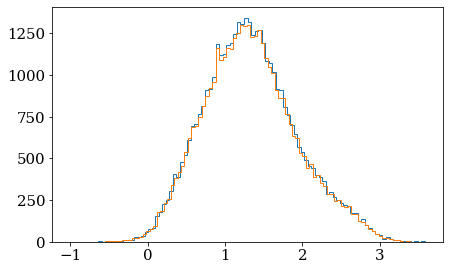

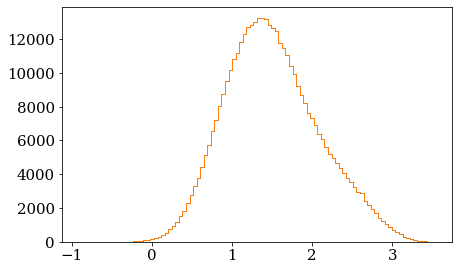

In [348]:
plt.hist(dfs_data['C_pi_p'].eval('diff_rap_cm'),bins=100,histtype='step')
plt.hist(dfs_data['C_pi_p'].eval('0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))'),bins=100,histtype='step')
plt.show()
plt.hist(dfs_mixed['C_pi_p'].eval('diff_rap_cm'),bins=100,histtype='step')
plt.hist(dfs_mixed['C_pi_p'].eval('0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))'),bins=100,histtype='step')
plt.show()


[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


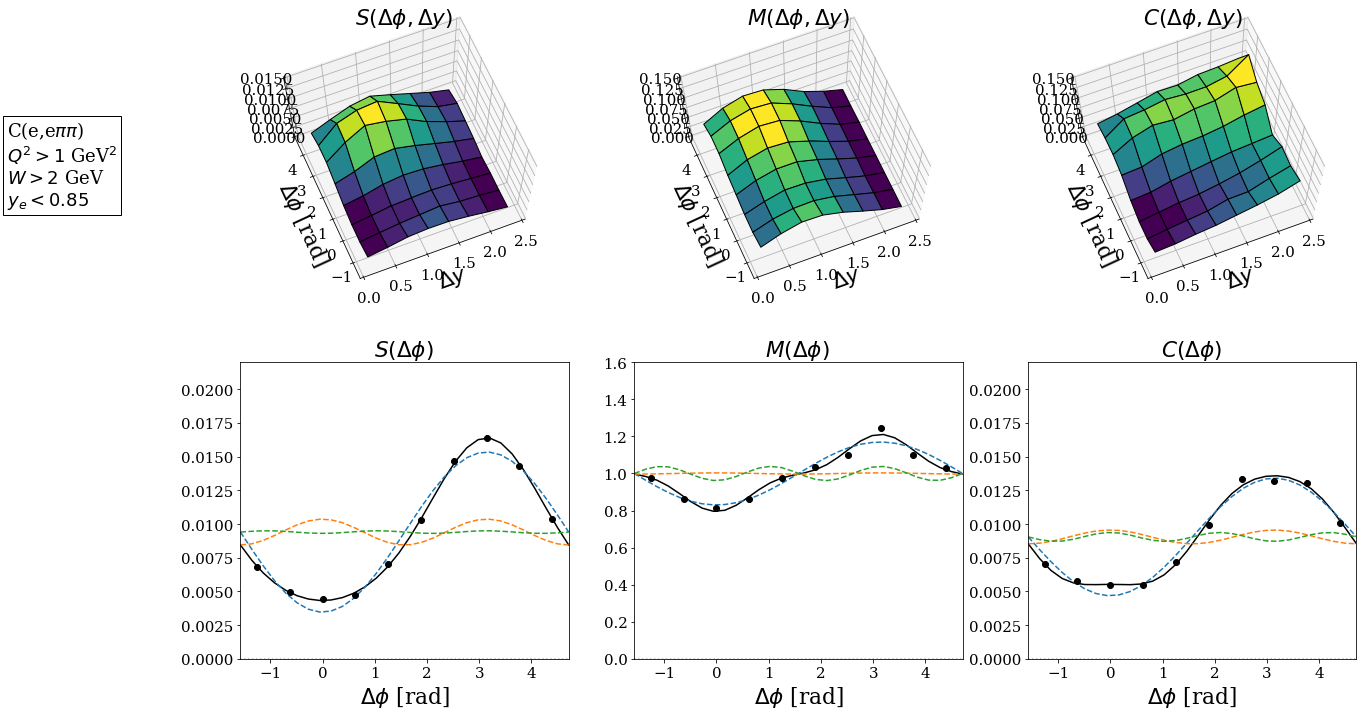

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


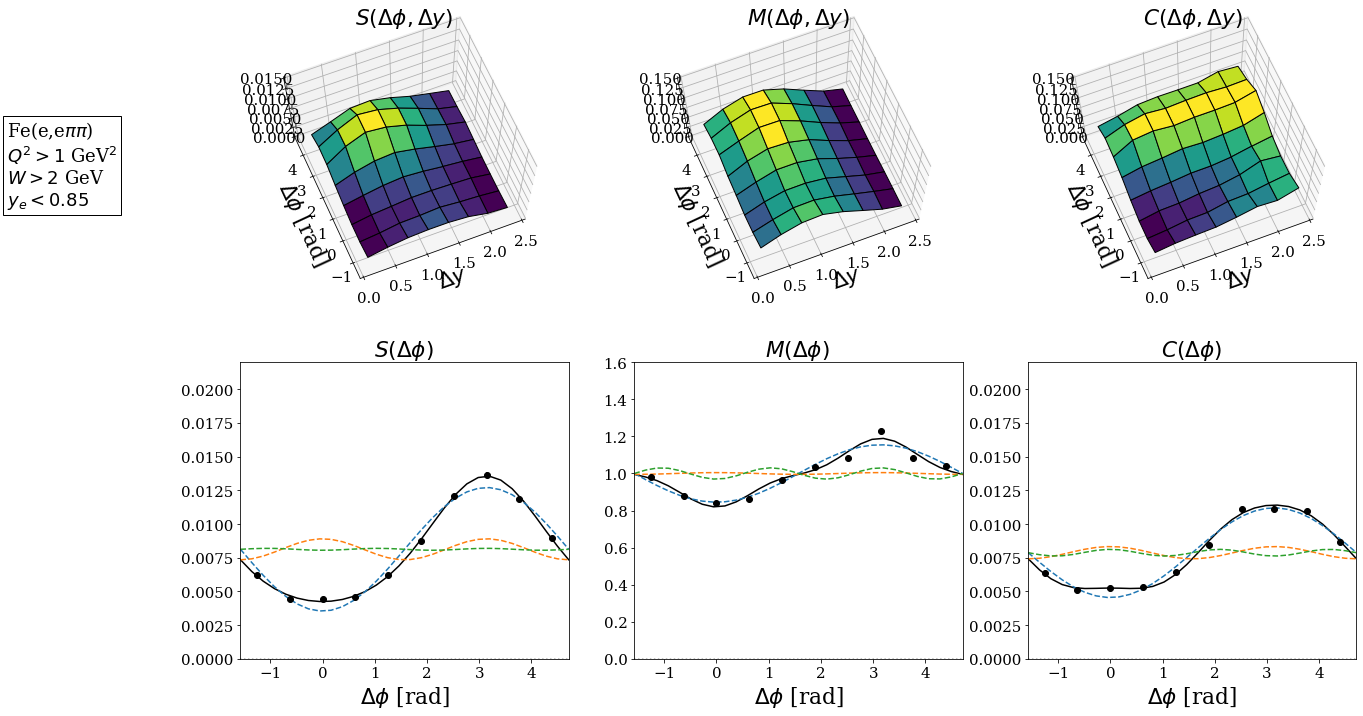

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


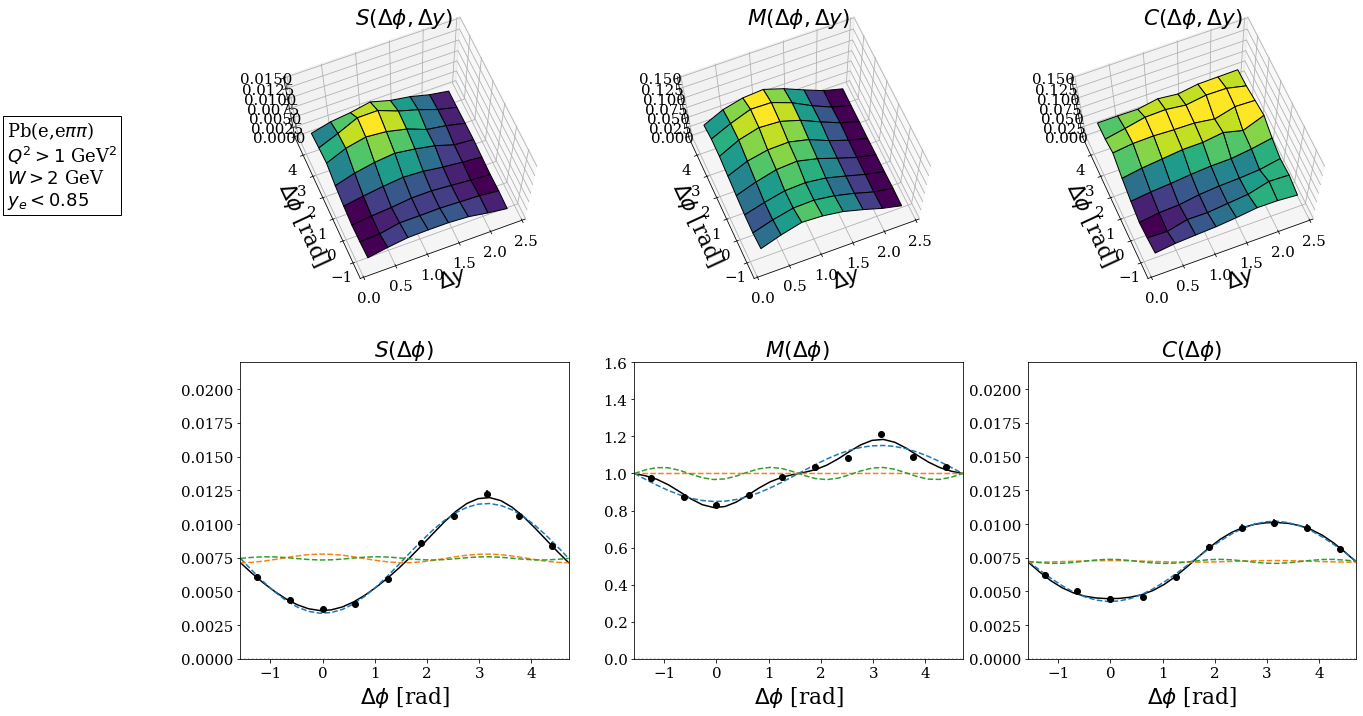

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


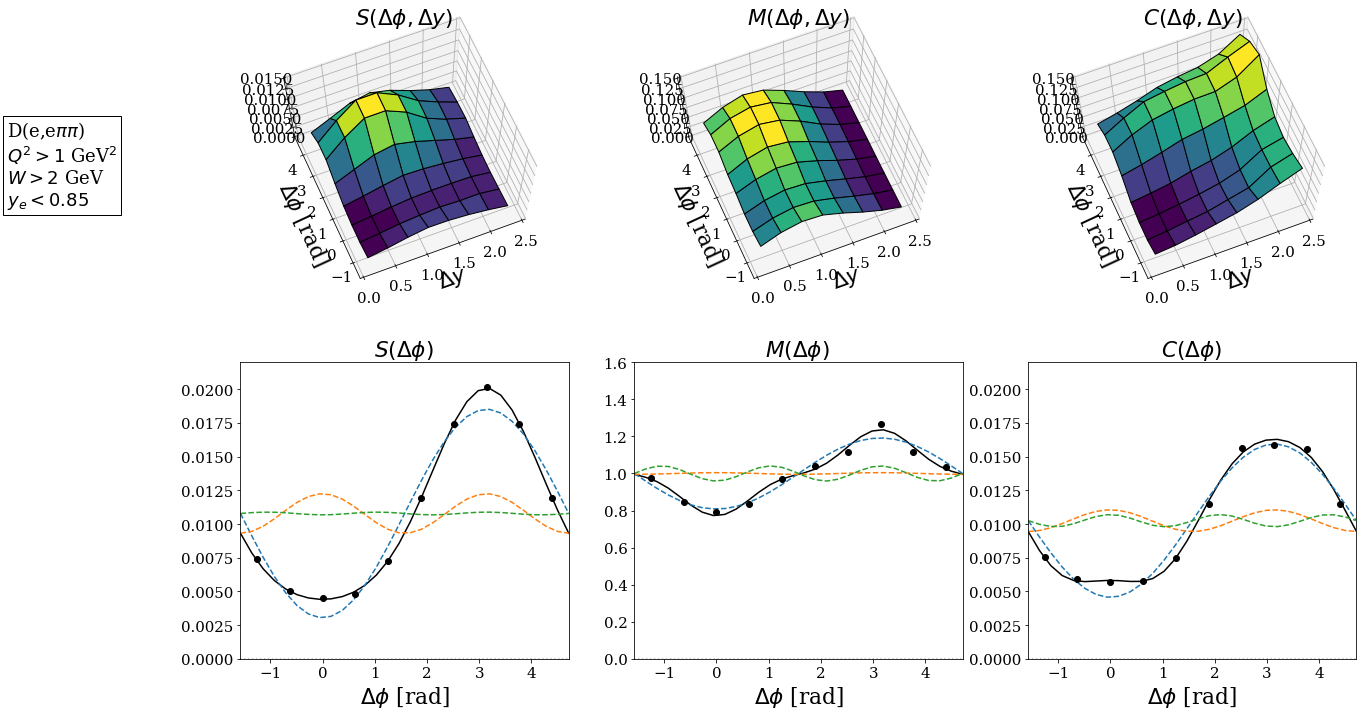

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


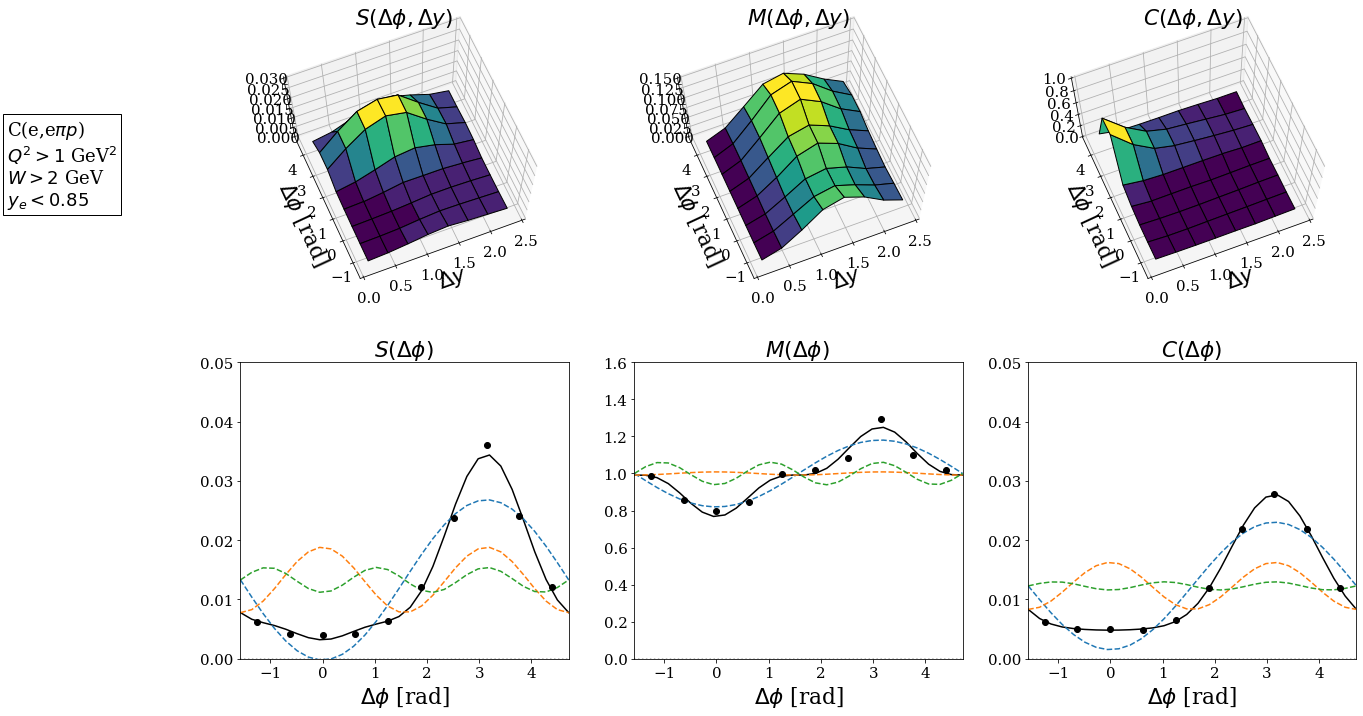

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


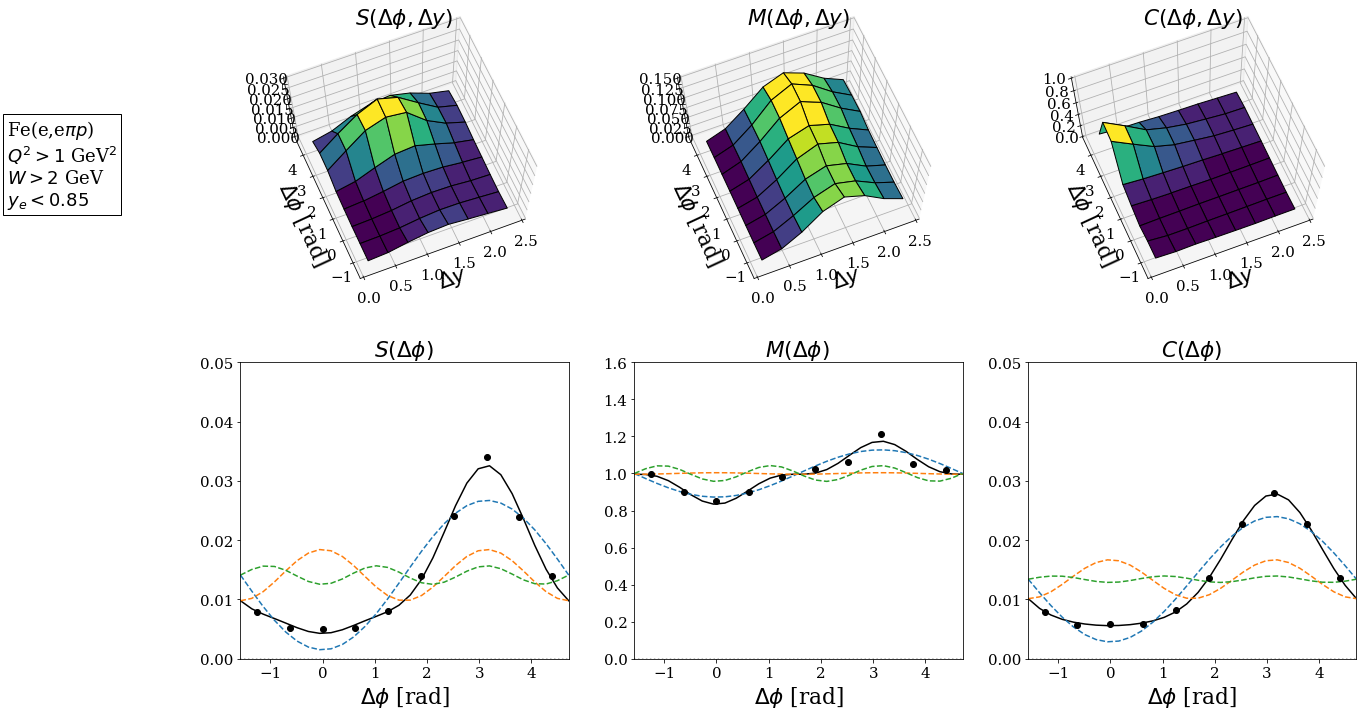

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


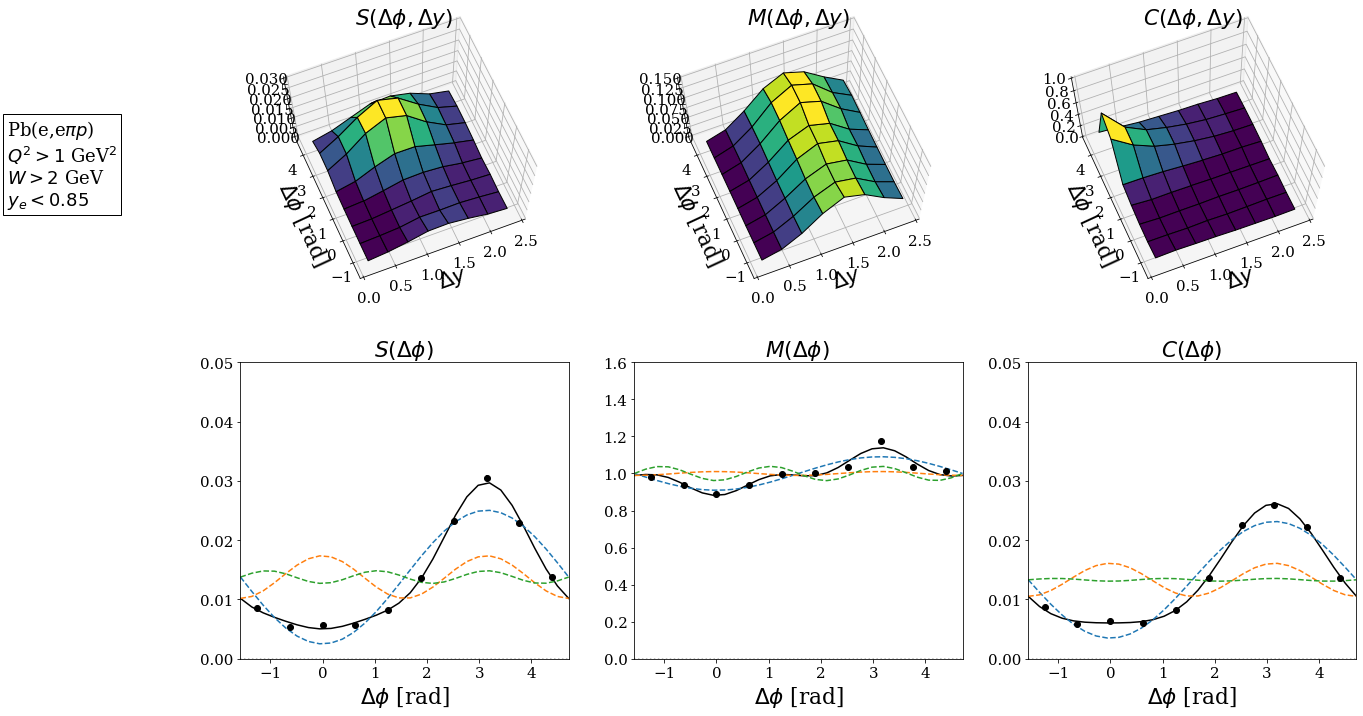

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


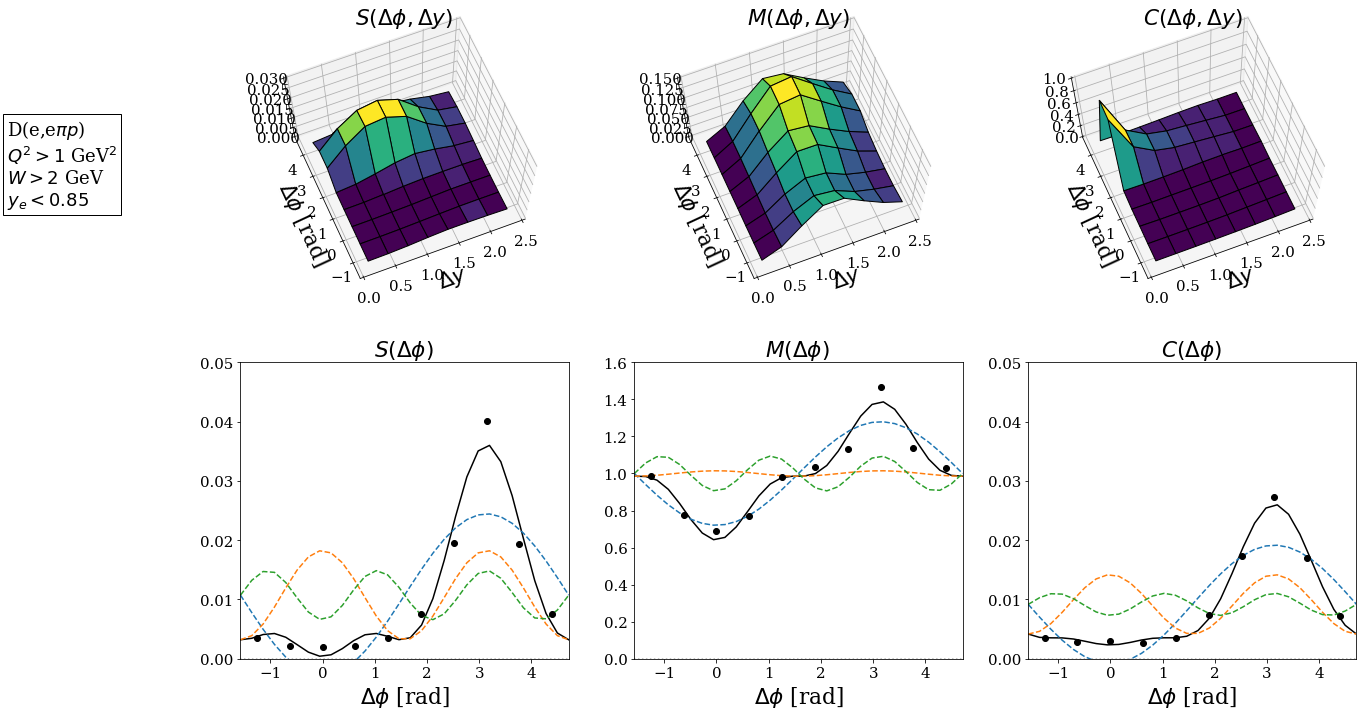

In [453]:
imp.reload(correlation_plots)
query = "h2_z>0.1"
labels = {'_2pi': '$\\pi\\pi$', '_pi_p':'$\\pi p$'}
for topo in '_2pi _pi_p'.split():
    for a in 'C Fe Pb D'.split():
        data = dfs_data[a+topo].query(query)
        mixed = dfs_mixed[a+topo].query(query)
        triggers = dfs_trigger[a]
        if topo == '_2pi':
            zlims = ((0,0.015),(0,0.15),(0,0.15))
            ylims = ((0,0.022),(0,1.6),(0,0.022))
        else :
            zlims = ((0,0.03),(0,0.15),(0,1))
            ylims = ((0,0.05),(0,1.6),(0,0.05))
        fig,axs = correlation_plots.dphi_deta_plot_3_proj(data,mixed,df_triggers=triggers,
                      deta_range=(0,2.5),projyrange=(0,2.5),bins=8,bins1d=10,
                      text=a + "(e,e"+ labels[topo]+")\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$y_e<0.85$",
                        zlims=zlims,ylims=ylims)
        #axs[4].errorbar(*pi_p_M_from_mc,color='g',marker='o') 
        #axs[4].text(-0.5,0.027,"correction from event mixing",fontsize=18,color='k')
        #axs[4].text(-0.5,0.01,"alt. correction from MC",fontsize=18,color='g') 
        plt.savefig(image_dir + "/smc_EG2_%s%s.pdf" %(a,topo),bbox_inches='tight')
        plt.show()
        gc.collect()

1

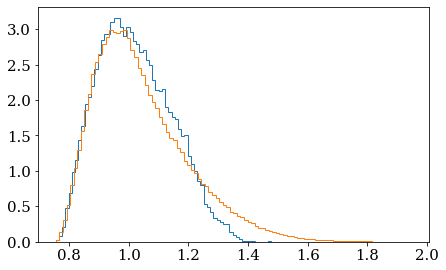

In [317]:
plt.hist(dfs_data['C_pi_p'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.hist(dfs_mixed['C_pi_p'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
1

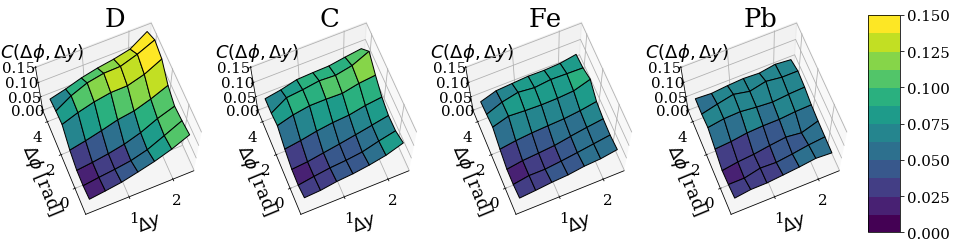

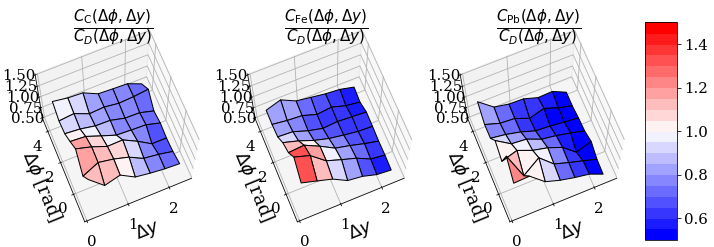

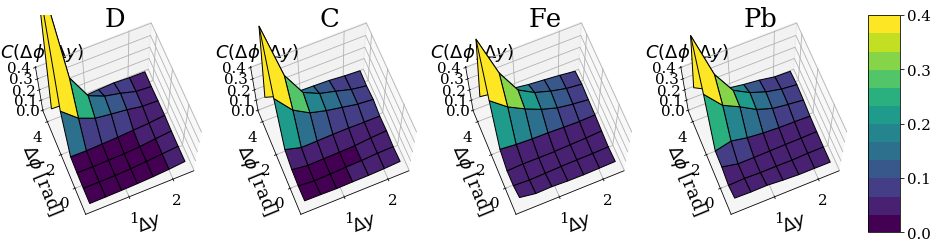

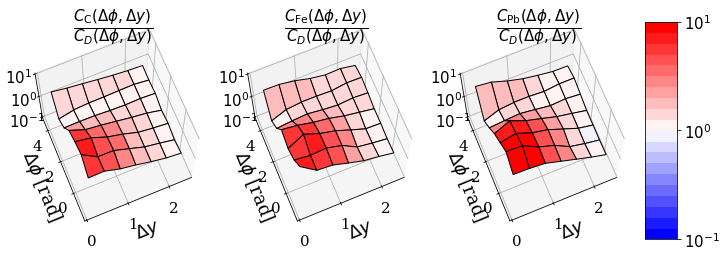

In [496]:
import corr_plots_nuclear
imp.reload(corr_plots_nuclear)
targets = 'D C Fe Pb D_C D_Fe D_Pb'.split()
q = 'h2_z>0.1 and h1_z>0.5'

projyrange =(0,2.5)
bins = 7
corr_plots_nuclear.summary_plot([dfs_data[a + '_2pi'].query(q) for a in targets],
                                [dfs_mixed[a + '_2pi'].query(q) for a in targets],
                                [dfs_trigger[a] for a in targets], bins=bins,projyrange=projyrange,
                                text="$\\pi\\pi$\n$Q^2>1$ GeV$^2$\n$y_e<0.85$\n$W>2$ GeV",
                                zlims=(0,0.15),zlimrat=(0.5,1.5),include_1d=False,topRowOnly=True)
plt.savefig(image_dir + "/summary_2d_2pi_top.pdf",bbox_inches='tight')

corr_plots_nuclear.summary_plot([dfs_data[a + '_2pi'].query(q) for a in targets],
                                [dfs_mixed[a + '_2pi'].query(q) for a in targets],
                                [dfs_trigger[a] for a in targets], bins=bins,projyrange=projyrange ,
                                text="$\\pi\\pi$\n$Q^2>1$ GeV$^2$\n$y_e<0.85$\n$W>2$ GeV",
                                zlims=(0,0.15),zlimrat=(0.5,1.5),include_1d=False,bottomRowOnly=True)
plt.savefig(image_dir + "/summary_2d_2pi_bottom.pdf",bbox_inches='tight')


corr_plots_nuclear.summary_plot([dfs_data[a + '_pi_p'].query(q) for a in targets],
                                [dfs_mixed[a + '_pi_p'].query(q) for a in targets],
                                [dfs_trigger[a] for a in targets],projyrange=projyrange,bins=bins,ylimrat=(0,.1), 
                                zlims=(0,0.4),text="$\\pi p$\n$Q^2>1$ GeV$^2$\n$y_e<0.85$\n$W>2$ GeV",
                                zlimrat=(.1,10),include_1d=False,topRowOnly=True,logzrat=True)
plt.savefig(image_dir + "/summary_2d_pi_p_top.pdf",bbox_inches='tight')

corr_plots_nuclear.summary_plot([dfs_data[a + '_pi_p'].query(q) for a in targets],
                                [dfs_mixed[a + '_pi_p'].query(q) for a in targets],
                                [dfs_trigger[a] for a in targets],projyrange=projyrange,bins=bins,ylimrat=(0,.1), 
                                zlims=(0,0.4),text="$\\pi p$\n$Q^2>1$ GeV$^2$\n$y_e<0.85$\n$W>2$ GeV",
                                zlimrat=(.1,10),include_1d=False,bottomRowOnly=True,logzrat=True,surfrat=True)
plt.savefig(image_dir + "/summary_2d_pi_p_bottom.pdf",bbox_inches='tight')

(1, 10)

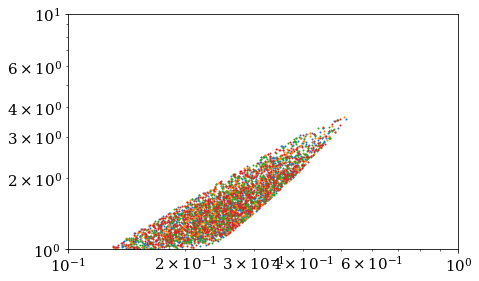

In [413]:
n=1000
for a in 'D C Fe Pb'.split():
    plt.scatter(dfs_data[a+'_2pi'][:n].x,dfs_data[a+'_2pi'][:n].Q2,1)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.gca().set_xlim(0.1,1)
plt.gca().set_ylim(1,10)

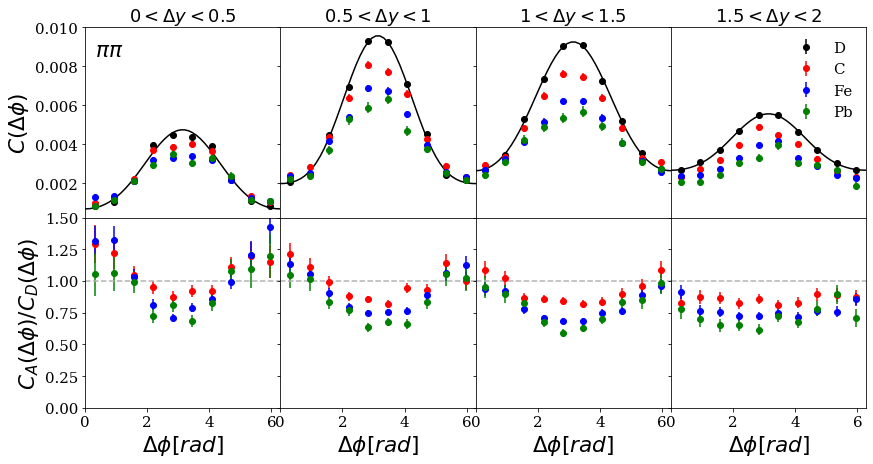

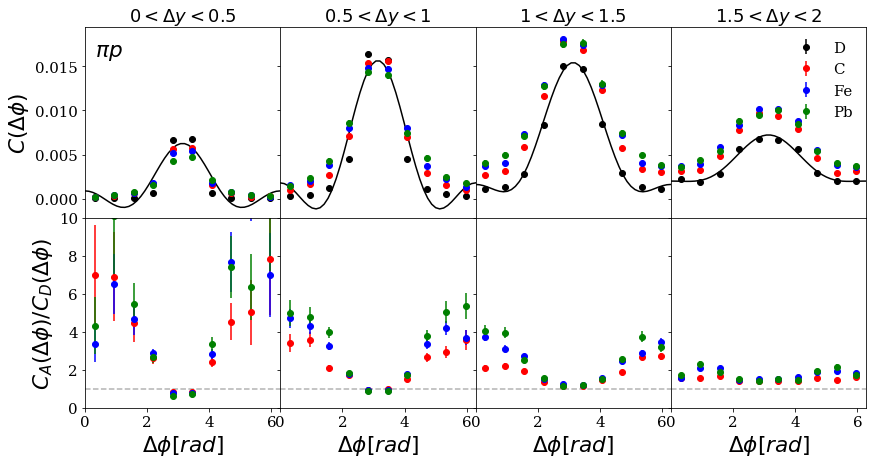

In [450]:

imp.reload(correlation_plots)
for label,topo,fillstyle,linestyleFit in zip('$\\pi\\pi$ $\\pi{}p$'.split(),
                                             '_2pi _pi_p'.split(),'full full'.split(), '----'):
    
    dyranges = [(0,0.5), (0.5,1), (1,1.5),(1.5,2)]
    fig,axs = plt.subplots(2,len(dyranges),figsize=(14,7),sharex='all',sharey='row')
    
    for j,dyrange in enumerate(dyranges):
        query = f"h2_z>0.1 and h1_z>0.5"
        if dyrange:
             query += f" and diff_rap_cm>{dyrange[0]} and diff_rap_cm<{dyrange[1]}"
        for a,col in zip('D C Fe Pb'.split(),"krbg"):
            A = dfs_data[a+topo].query(query)
            triggers_A = dfs_trigger[a].query('h1_z>0.5')
            mix_A = dfs_mixed[a+topo].query(query) 

            if a != 'D':
                D = dfs_data['D_'+a+topo].query(query)
                triggers_D = dfs_trigger['D_'+a].query('h1_z>0.5')
                mix_D = dfs_mixed['D_'+a+topo].query(query) 

            plt.sca(axs[0][j])
            #nuclear
            correlation_plots.general_1D_plot(A,None,df_triggers_A=triggers_A,
                          projyrange=(-1,3.0),bins1d=10,
                                                  df_mix_A=mix_A,color=col,label=a,
                                              plotFourier=2,fillstyle=fillstyle,linestyleFit='-' if a == 'D' else '')
            plt.sca(axs[1][j])
            #nuclear
            if a != 'D':
                correlation_plots.general_1D_plot(A,D,df_triggers_A=triggers_A,df_triggers_D=triggers_D,
                          projyrange=(-1,3.0),bins1d=10,
                                                  df_mix_A=mix_A,df_mix_D=mix_D,color=col,label=a,
                                              plotFourier=2 if topo=='_2pi' else 3,fillstyle=fillstyle,linestyleFit='-' if a == 'D' else '')
            plt.gca().set_xlim(0,2*np.pi)

        for ax in axs[1]:
            ax.set_xlabel("$\\Delta\\phi [rad]$")
        axs[1][j].axhline(1,color='0.7', linestyle='--')
        if topo=='_2pi':
            axs[1][j].set_ylim(0,1.5)
        else:
            axs[1][j].set_ylim(0,10)
            
        dyrangestr = f"${dyrange[0]}<\Delta y<{dyrange[1]}$" if dyrange else "all"
        axs[0][j].set_title(dyrangestr,fontsize='large')
    axs[0][0].text(.05,0.85, label,transform=axs[0][0].transAxes,fontsize='x-large')
        
    
    axs[0][0].set_ylabel("$C(\\Delta\\phi)$")
    axs[1][0].set_ylabel("$C_A(\\Delta\\phi)/C_D(\\Delta\\phi)$")
    axs[0][-1].legend(framealpha=0)
    fig.subplots_adjust(hspace=0,wspace=0)
    plt.savefig(image_dir+f"/summary_1d{topo}_slices.pdf",bbox_inches='tight')
    plt.show()

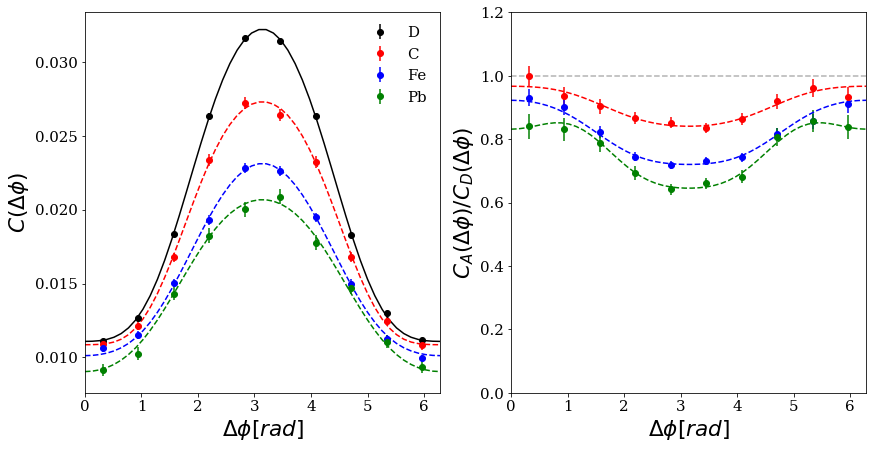

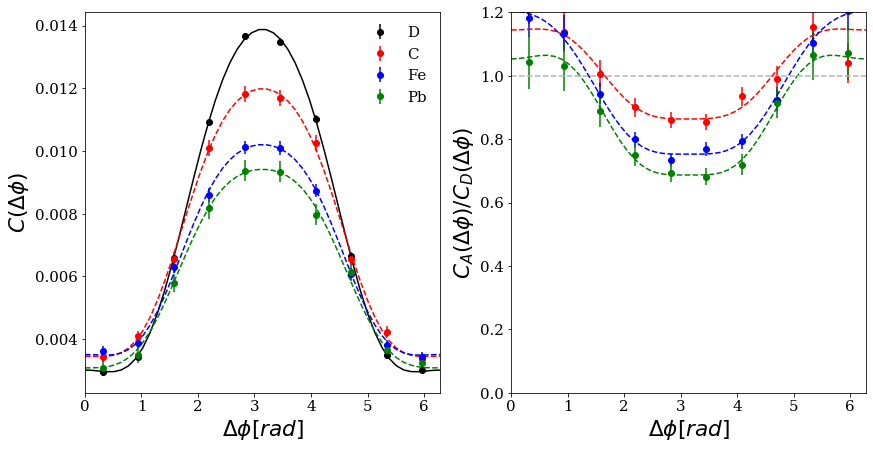

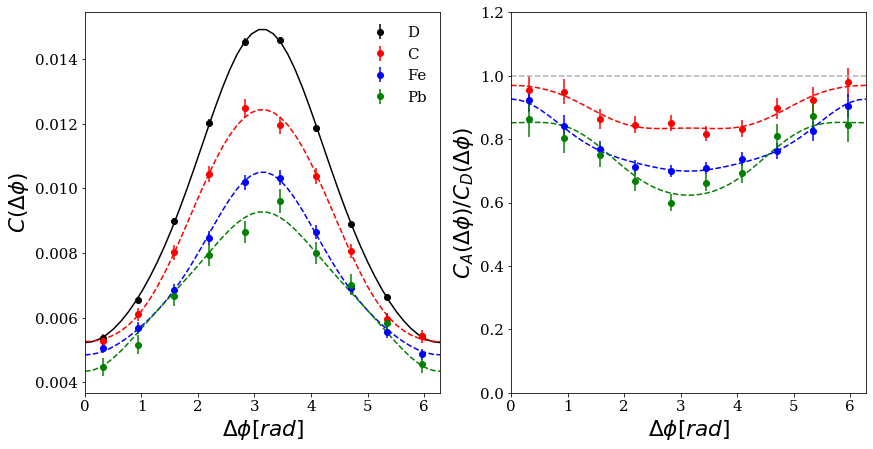

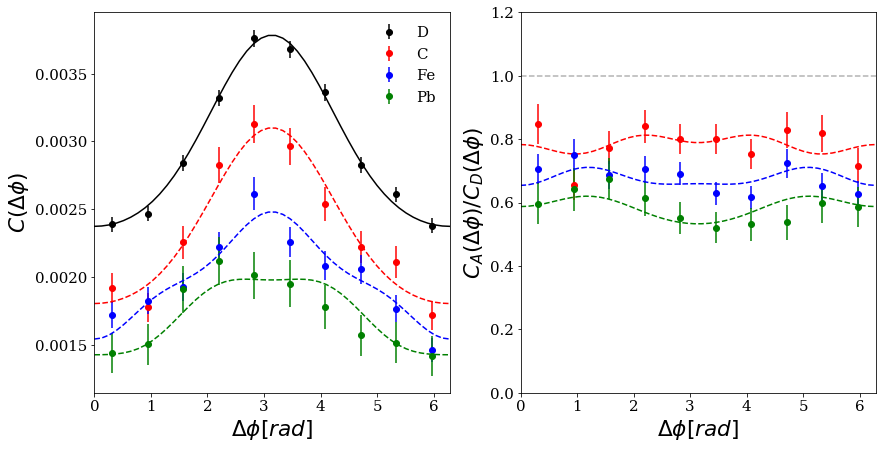

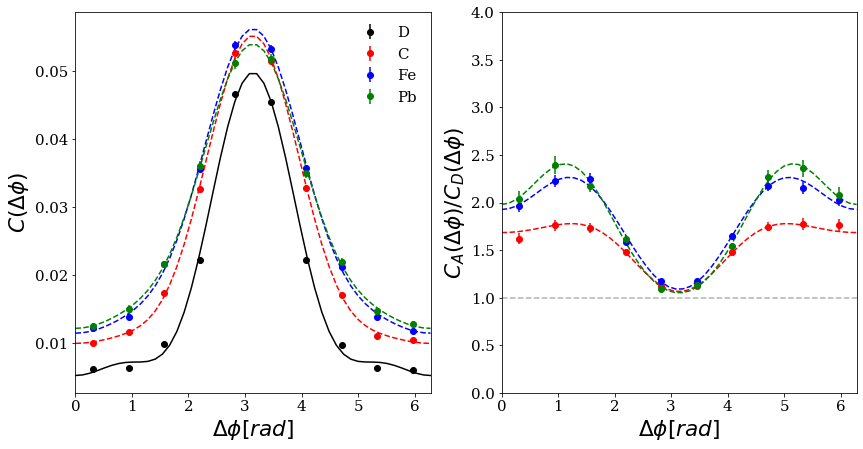

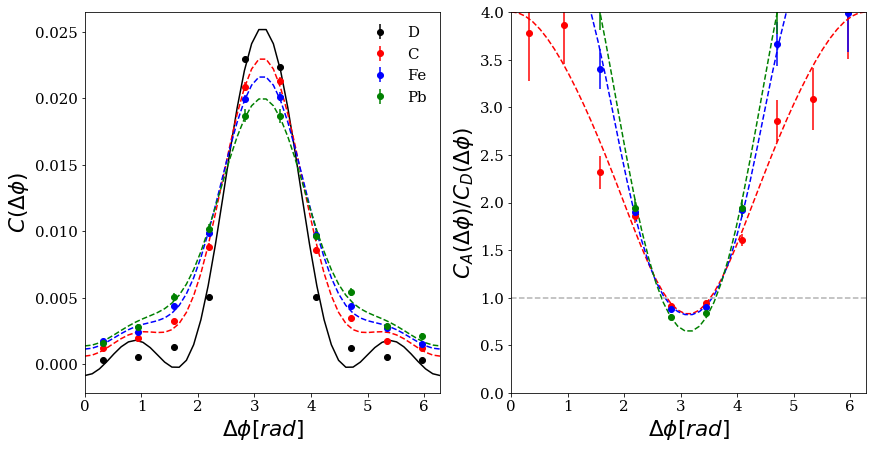

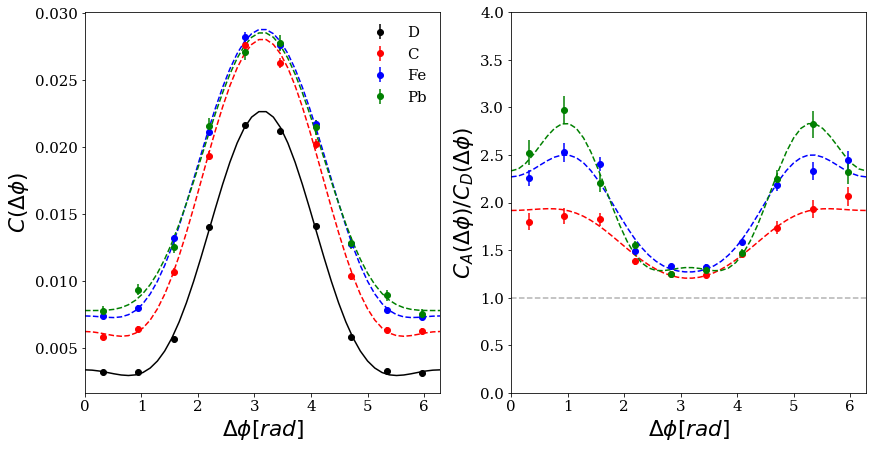

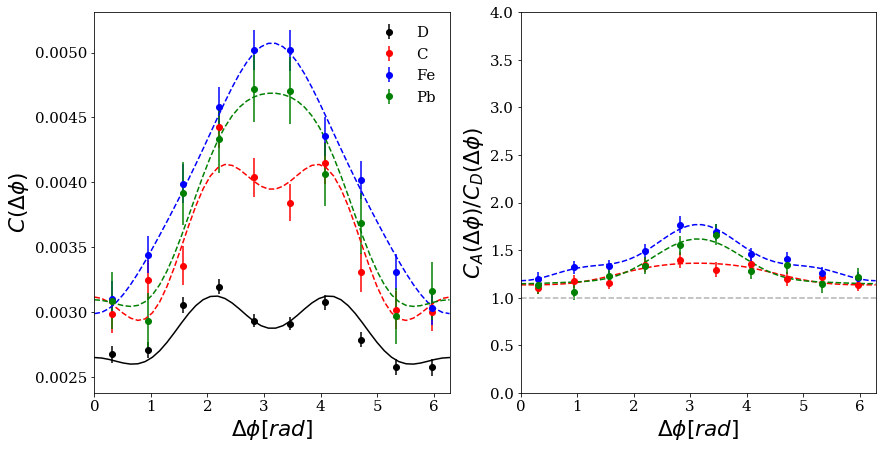

In [500]:

imp.reload(correlation_plots)
for label,topo,fillstyle,linestyleFit in zip('$\\pi\\pi$ $\\pi{}p$'.split(), '_2pi _pi_p'.split(),'full full'.split(), '- -'.split()):
    for dyrange in None, (0,1), (1,2),(2,3):
        
        fig,axs = plt.subplots(1,2,figsize=(14,7),sharex='all')
        query = f"h2_z>0.1 and h1_z>0.5"
        if dyrange:
             query += f" and diff_rap_cm>{dyrange[0]} and diff_rap_cm<{dyrange[1]}"
        for a,col in zip('D C Fe Pb'.split(),"krbg"):
            linestyleFit='-' if a == 'D' else '--'
            A = dfs_data[a+topo].query(query)
            triggers_A = dfs_trigger[a].query('h1_z>0.5')
            mix_A = dfs_mixed[a+topo].query(query) 

            if a != 'D':
                D = dfs_data['D_'+a+topo].query(query)
                triggers_D = dfs_trigger['D_'+a].query('h1_z>0.5')
                mix_D = dfs_mixed['D_'+a+topo].query(query) 

            plt.sca(axs[0])
            #nuclear
            correlation_plots.general_1D_plot(A,None,df_triggers_A=triggers_A,
                          projyrange=(0,3.0),bins1d=10,
                                                  df_mix_A=mix_A,color=col,label=a,
                                              plotFourier=3,fillstyle=fillstyle,linestyleFit=linestyleFit)
            plt.sca(axs[1])
            #nuclear
            if a != 'D':
                correlation_plots.general_1D_plot(A,D,df_triggers_A=triggers_A,df_triggers_D=triggers_D,
                          projyrange=(0,3.0),bins1d=10,
                                                  df_mix_A=mix_A,df_mix_D=mix_D,color=col,label=a,
                                              plotFourier=3,fillstyle=fillstyle,linestyleFit=linestyleFit)
            plt.gca().set_xlim(0,2*np.pi)

        for ax in axs:
            ax.set_xlabel("$\\Delta\\phi [rad]$")
        axs[0].set_ylabel("$C(\\Delta\\phi)$")
        axs[1].set_ylabel("$C_A(\\Delta\\phi)/C_D(\\Delta\\phi)$")
        axs[1].axhline(1,color='0.7', linestyle='--')
        if topo=='_2pi':
            axs[1].set_ylim(0,1.2)
        else:
            axs[1].set_ylim(0,4)

        axs[0].text(.05,0.85, label,transform=plt.gca().transAxes,fontsize='x-large')
        axs[0].text(.05,0.75, "1<$Q^2$<4 GeV$^2$\n$y$<0.85",transform=plt.gca().transAxes)
        axs[0].legend(framealpha=0)
        dyrangestr = f"_{dyrange[0]}_{dyrange[1]}" if dyrange else ""
        plt.savefig(image_dir+f"/summary_1d{topo}{dyrangestr}.pdf",bbox_inches='tight')
        plt.show()

[1.   1.25 1.5  1.75 2.   2.25 2.5 ]
i= 1


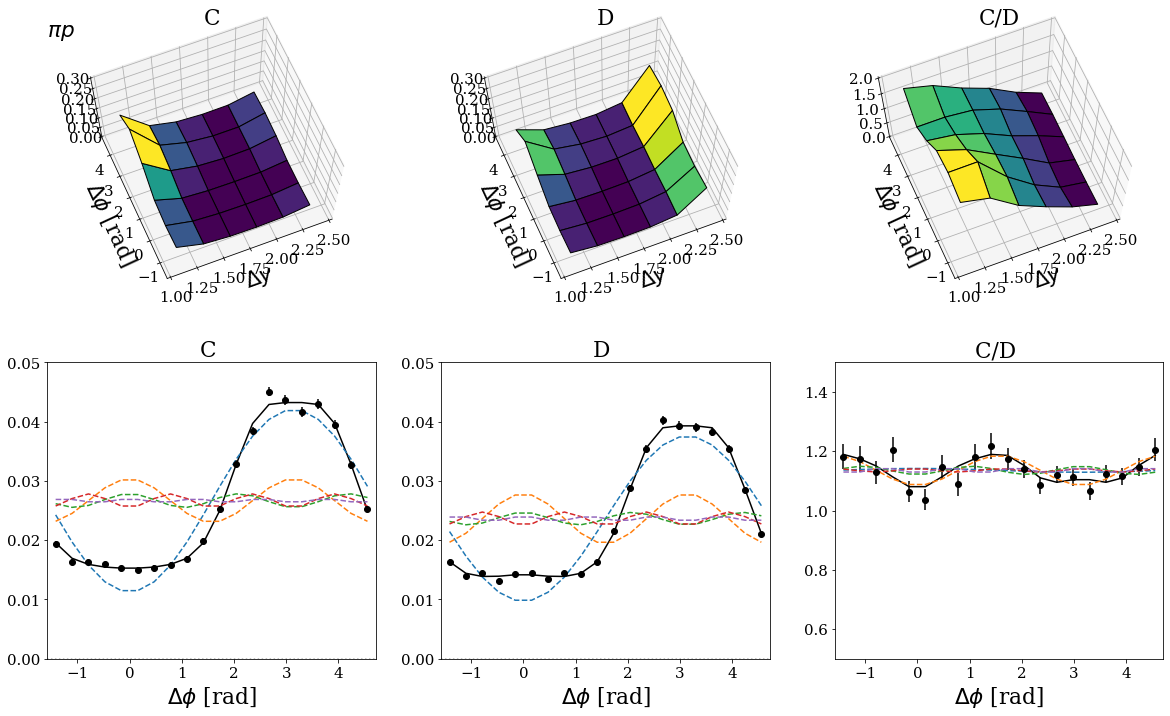

[1.   1.25 1.5  1.75 2.   2.25 2.5 ]
i= 1


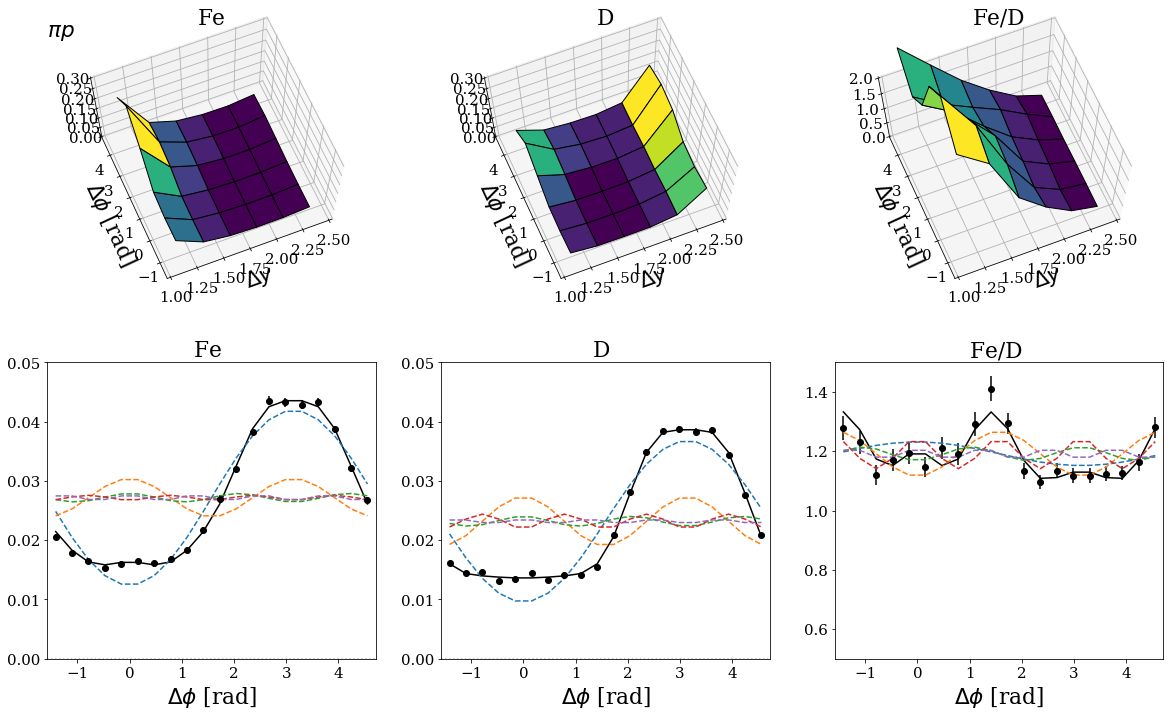

[1.   1.25 1.5  1.75 2.   2.25 2.5 ]
i= 1


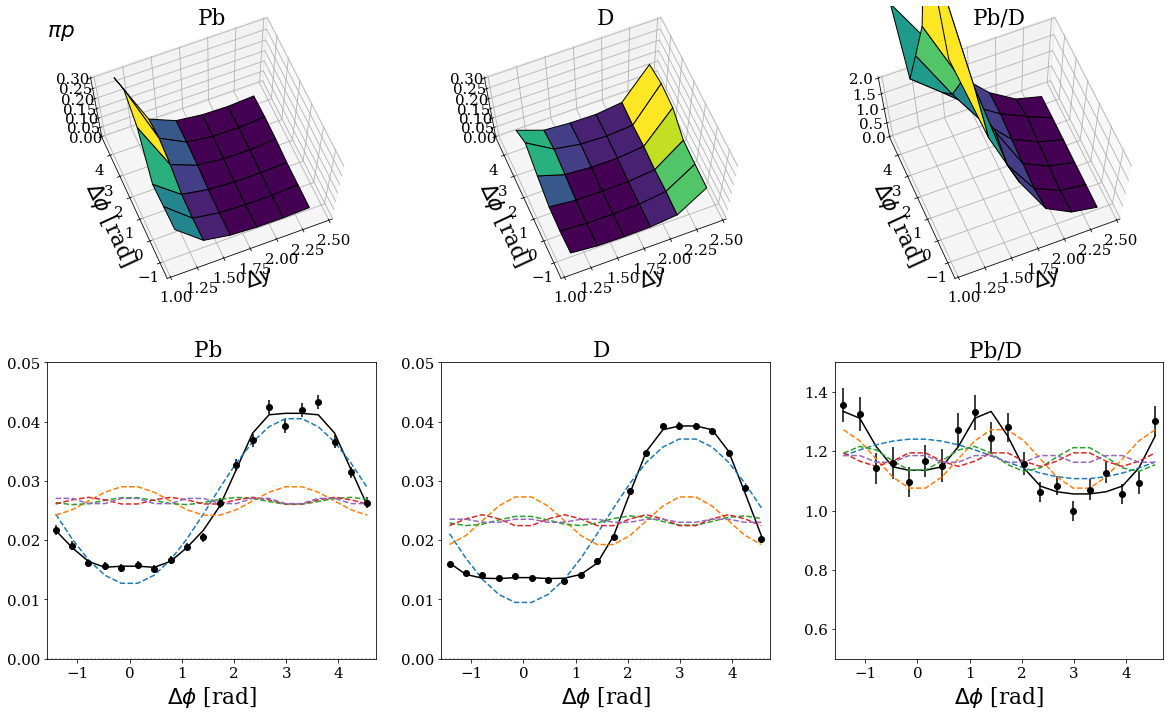

[0.         0.33333333 0.66666667 1.         1.33333333 1.66666667
 2.        ]
i= 1


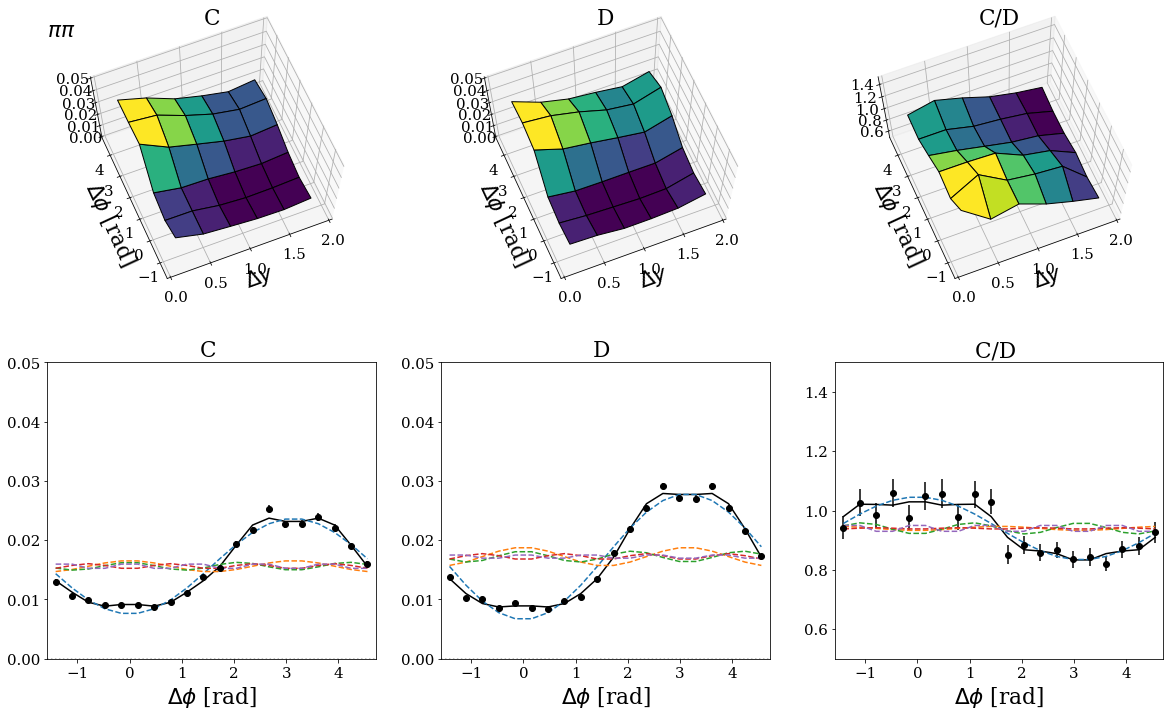

[0.         0.33333333 0.66666667 1.         1.33333333 1.66666667
 2.        ]
i= 1


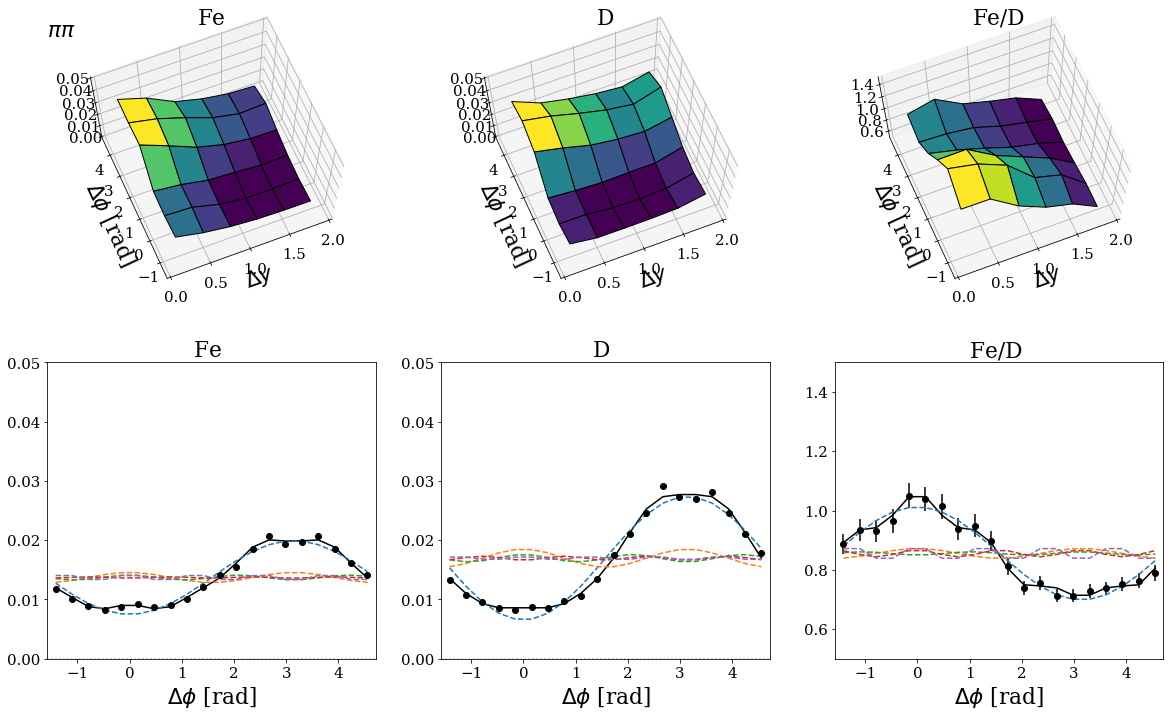

[0.         0.33333333 0.66666667 1.         1.33333333 1.66666667
 2.        ]
i= 1


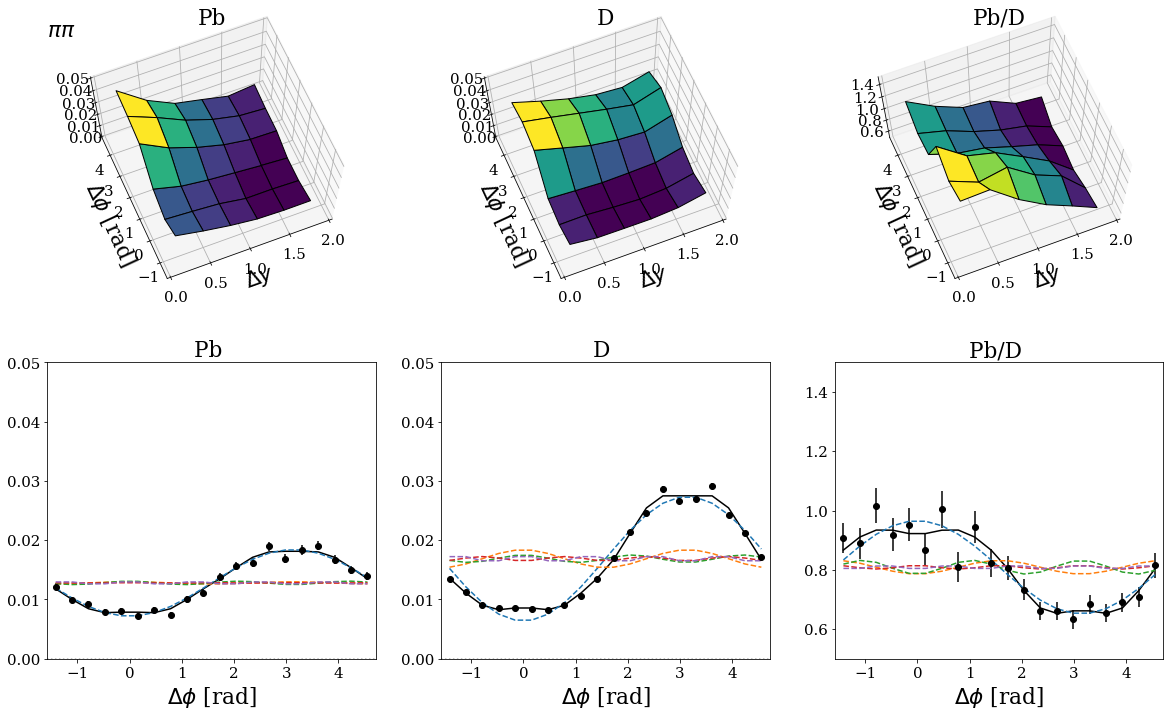

In [155]:

imp.reload(correlation_plots)
useMix=True

labels = {'_2pi': '$\\pi\\pi$', '_pi_p':'$\\pi p$'}
for topo in '_pi_p','_2pi':
    query = "h2_z>0.1 and h1_z>0.5"
    for a in 'C Fe Pb'.split():
        A = dfs_data[a+topo].query(query)
        D = dfs_data["D_" +a+topo].query(query)
        triggers_A = dfs_trigger[a].query('h1_z>0.5')
        triggers_D = dfs_trigger["D_" + a].query('h1_z>0.5')
        
        mix_A = dfs_mixed[a+topo].query(query) if useMix else None
        mix_D = dfs_mixed["D_" + a+topo].query(query) if useMix else None
        
        ylim=(0,0.05)
        zlim=(0,0.05) if topo =='_2pi' else (0, .3)
        zlimrat=(0.5,1.5) if topo =='_2pi' else (0, 2)
        projyrange=(0,2.0) if topo == '_2pi' else (1,2.5)
        fig,axs = correlation_plots.NoverD_2x3(A,D,df_triggers_A=triggers_A,df_triggers_D=triggers_D,
                      deta_range=projyrange,projyrange=projyrange,text=None,bins=6,bins1d=20,
                            label_A=a,label_other=labels[topo],ylim=ylim,ylimrat=(0.5,1.5),
                                              zlim=zlim,zlimrat=zlimrat,
                                              df_mix_A=mix_A,df_mix_D=mix_D)
        #axs[4].errorbar(*pi_p_M_from_mc,color='g',marker='o') 
        #axs[4].text(-0.5,0.027,"correction from event mixing",fontsize=18,color='k')
        #axs[4].text(-0.5,0.01,"alt. correction from MC",fontsize=18,color='g') 
        plt.savefig(image_dir + "/ADR_EG2_%s%s.pdf" %(a,topo),bbox_inches='tight')
        plt.show()
        gc.collect()

In [ ]:
query = "h2_z>0.1 and h1_z>0.5"

imp.reload(correlation_plots)

for a in 'C Fe Pb'.split():
    A = dfs_data[a].query(query)
    D = dfs_data["D_" +a].query(query)
    triggers_A = dfs_trigger[a].query('h1_z>0.5')
    triggers_D = dfs_trigger["D_" + a].query('h1_z>0.5')

    mix_A = dfs_mixed[a].query(query) if useMix else None
    mix_D = dfs_mixed["D_" + a].query(query) if useMix else None

    ylim=(0,0.05)
    correlation_plots.general_1D_plot(A,D,df_triggers_A=triggers_A,df_triggers_D=triggers_D,
                  projyrange=(0,2.0),bins1d=10,
                                          df_mix_A=mix_A,df_mix_D=mix_D,color=None,label=a)
plt.legend()
plt.show()

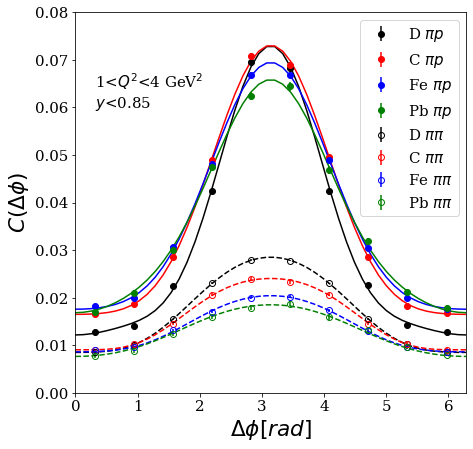

In [184]:
query = "h2_z>0.1 and h1_z>0.5"
imp.reload(correlation_plots)
fig,axs = plt.subplots(1,1,figsize=(7,7),sharey='all',sharex='all')
for label,topo,fillstyle,linestyleFit in zip('$\\pi{}p$ $\\pi\\pi$'.split(), '_pi_p _2pi'.split(),'full none'.split(), '- --'.split()):
    
    
    plt.gca().set_ylabel("$C(\\Delta\\phi)$")
    plt.gca().set_xlabel("$\\Delta\\phi [rad]$")

    for a,col in zip('D C Fe Pb'.split(),"krbg"):
        A = dfs_data[a+topo].query(query)
        triggers_A = dfs_trigger[a].query('h1_z>0.5')

        mix_A = dfs_mixed[a+topo].query(query) 

        ylim=(0,0.05)
        #nuclear
        correlation_plots.general_1D_plot(A,None,df_triggers_A=triggers_A,
                      projyrange=(0,2.0),bins1d=10,
                                              df_mix_A=mix_A,color=col,label=a + " "+label,
                                          plotFourier=3,fillstyle=fillstyle,linestyleFit=linestyleFit)

plt.gca().set_ylim(0,0.08)
plt.gca().set_xlim(0,2*np.pi)
plt.text(.05,0.75, "1<$Q^2$<4 GeV$^2$\n$y$<0.85",transform=plt.gca().transAxes)
plt.legend()
plt.show()

1

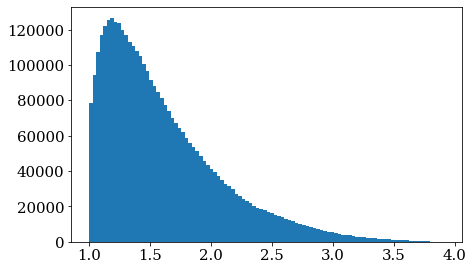

In [166]:
plt.hist(dfs_data['D'].Q2,bins=100)
1

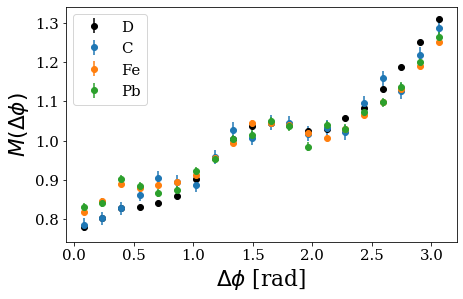

In [108]:
#no mixing
for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    mixed = dfs_mixed[a]
    y,x = np.histogram(abs(mixed.diff_phi_cm),bins=20, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    y = np.divide(y,denom)
    dy = np.divide(dy,denom)
    plt.errorbar(x,y,dy,color=color,linestyle='',label=a,marker='o')
plt.legend()
plt.gca().set_ylabel("$M(\\Delta\\phi)$")
plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
plt.show()  


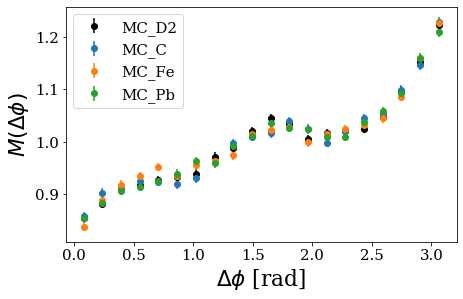

In [149]:
#no mixing
for a,color in zip('MC_D2 MC_C MC_Fe MC_Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    mixed = dfs_mixed[a]
    y,x = np.histogram(abs(mixed.diff_phi_cm),bins=20, range=(0,np.pi))
    x = np.add(x[:-1],x[1:])/2
    dy = np.sqrt(y)
    denom = np.mean(y)
    y = np.divide(y,denom)
    dy = np.divide(dy,denom)
    plt.errorbar(x,y,dy,color=color,linestyle='',label=a,marker='o')
plt.legend()
plt.gca().set_ylabel("$M(\\Delta\\phi)$")
plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
plt.show()  

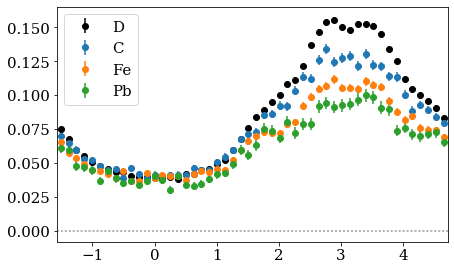

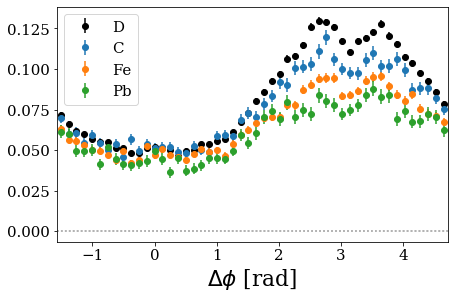

In [18]:

#no mixing
for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    data = dfs_data[a]
    mixed = dfs_mixed[a]
    correlation_plots.corr1d(data,None,projyrange=(-10,10),color=color,showFourier=False,label=a,Ntriggers=len(dfs_trigger[a]))
plt.legend()
plt.show()    

#with mixing correction
for a,color in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split()):
    data = dfs_data[a]
    mixed = dfs_mixed[a]
    correlation_plots.corr1d(data,mixed,projyrange=(-10,10),color=color,showFourier=False,label=a,Ntriggers=len(dfs_trigger[a]))
plt.legend()
plt.show()    

245130 337329
37019 55467
289603 504506
38334 81463
105340 523227
12836 84259


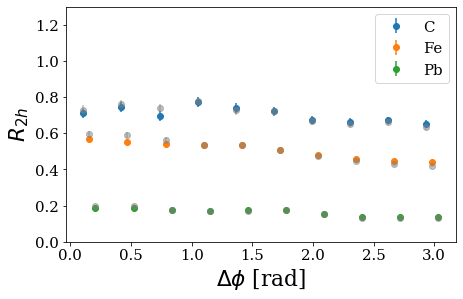

In [74]:
#with mixing correction

imp.reload(correlation_plots)
bins = 10
q = "h1_z>0.5"
q_trig = "h1_z>0.5"
for a,color,offsetX in zip('C Fe Pb'.split(),"tab:blue tab:orange tab:green".split(),np.linspace(-0.05,.05,3)):
    data = dfs_data[a]
    mixed = dfs_mixed[a]
    data_D = dfs_data["D_"+a]
    mixed_D = dfs_mixed["D_"+a]
    
    ntrig = len(dfs_trigger[a].query(q_trig))
    ntrigD= len(dfs_trigger['D_'+a].query(q_trig))
    correlation_plots.corr1d_ratio(data.query(q),mixed.query(q),data_D.query(q),mixed_D.query(q),projyrange=(-10,10),color=color,showFourier=False,label=a,\
                             Ntriggers=ntrig,
                            NtriggersD=ntrigD,bins=10,offsetX=offsetX)
    correlation_plots.corr1d_ratio(data,None,data_D,None,projyrange=(-10,10),color='0.5',showFourier=False,label=None,\
                             Ntriggers=ntrig,
                            NtriggersD=ntrigD,bins=10,offsetX=offsetX,alpha=0.5)
    print(ntrig,ntrigD)
    print(len(data),len(data_D))
plt.legend()
plt.gca().set_ylabel("$R_{2h}$")
plt.gca().set_ylim(0,1.3) 
plt.savefig(image_dir + "/R2h.pdf",bbox_inches='tight')

all
C
x,y,dy
0.15708,1.04053,0.01358
0.47124,1.03313,0.01312
0.78540,1.03025,0.01293
1.09956,1.03138,0.01243
1.41372,0.98020,0.01111
1.72788,1.01212,0.01146
2.04204,0.97957,0.01107
2.35619,0.97141,0.01073
2.67035,0.97711,0.01046
2.98451,0.94431,0.00945
all
Fe
x,y,dy
0.15708,1.07047,0.01395
0.47124,1.06919,0.01364
0.78540,1.01201,0.01269
1.09956,0.98932,0.01184
1.41372,0.99327,0.01134
1.72788,0.97978,0.01096
2.04204,0.99879,0.01143
2.35619,0.97795,0.01095
2.67035,0.95992,0.01034
2.98451,0.94930,0.00967
all
Pb
x,y,dy
0.15708,1.04715,0.01455
0.47124,1.06602,0.01443
0.78540,1.02305,0.01378
1.09956,0.99729,0.01286
1.41372,0.99953,0.01234
1.72788,1.02039,0.01245
2.04204,0.97527,0.01198
2.35619,0.95524,0.01154
2.67035,0.96865,0.01129
2.98451,0.94741,0.01053
0.1<z2<0.15
C
x,y,dy
0.15708,1.07187,0.02794
0.47124,1.03815,0.02603
0.78540,1.04451,0.02657
1.09956,1.05484,0.02644
1.41372,0.98780,0.02321
1.72788,0.96658,0.02238
2.04204,0.99923,0.02359
2.35619,0.96896,0.02219
2.67035,0.95675,0.02141
2.

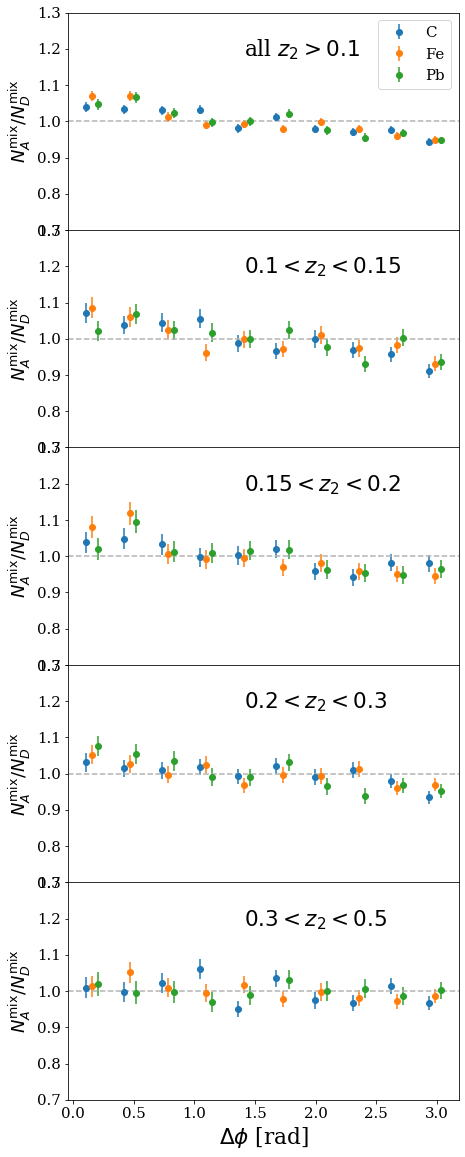

0.3<z2<0.5
C
x,y,dy
0.12500,1.14057,0.00856
0.17500,1.08122,0.00876
0.22500,1.02805,0.00930
0.27500,0.98219,0.01034
0.32500,0.95417,0.01175
0.37500,0.95588,0.01394
0.42500,0.96698,0.01648
0.47500,0.89093,0.01698
0.3<z2<0.5
Fe
x,y,dy
0.12500,1.29051,0.00975
0.17500,1.14144,0.00917
0.22500,1.03200,0.00933
0.27500,0.99784,0.01066
0.32500,0.91201,0.01142
0.37500,0.88245,0.01295
0.42500,0.86281,0.01468
0.47500,0.88094,0.01756
0.3<z2<0.5
Pb
x,y,dy
0.12500,1.34900,0.01068
0.17500,1.20933,0.01039
0.22500,1.08716,0.01065
0.27500,0.97565,0.01126
0.32500,0.91685,0.01269
0.37500,0.86129,0.01420
0.42500,0.78160,0.01507
0.47500,0.81913,0.01826


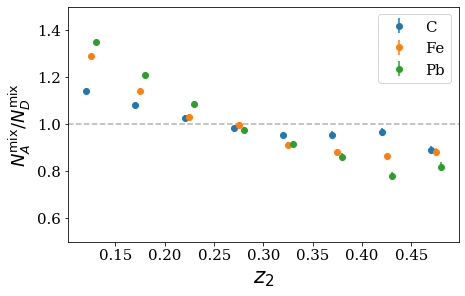

In [70]:
fig,axs = plt.subplots(5,1, figsize=(7,20),sharex='all',sharey='all')
fig.subplots_adjust(hspace=0)

yss = []
xss = []
dyss = []
for txt,lbl, q,ax in [["all","all $z_2>0.1$", "h1_z>0.5 and h2_z>0.1", axs[0]]]+\
                [[f"{mn}<z2<{mx}",f"${mn}<z_2<{mx}$", f"h1_z>0.5 and h2_z>{mn} and h2_z<{mx}",axs[i]] \
                       for mn,mx,i in ((0.1,0.15,1),(0.15,0.2,2),(0.2,0.3,3),(0.3,0.5,4))]:
    xoffset=0.05
    plt.sca(ax)
    ys = []
    xs = []
    dys = []
    for a,color,offsetX in zip('C Fe Pb'.split(),"tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,3)):
        mixed_A = dfs_mixed[a].query(q)
        mixed_D = dfs_mixed["D_"+a].query(q)

        bins = 10; rang=(0,np.pi);xvar = 'abs(diff_phi_cm)'

        x,y,dy = correlation_plots.plot_uncertainty_from_mixed(mixed_A,mixed_D,bins=bins,
               label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
        print(txt)
        print(a)
        print('x,y,dy')
        for i in range(len(x)):
            print("%.5f,%.5f,%.5f"%(x[i],y[i],dy[i]))
        ys.append(y)
        xs.append(x)
        dys.append(dy)
    plt.axhline(1, color='0.7',linestyle='--')
    plt.gca().set_ylabel("$N^{\\mathrm{mix}}_A/N^{\\mathrm{mix}}_D$",fontsize='large')
    plt.gca().set_xlabel('$\\Delta\\phi$ [rad]')
    plt.text(0.45, .8, lbl, fontsize='x-large', transform = plt.gca().transAxes)
    plt.gca().set_ylim(0.7,1.3)
    xss.append(xs)
    yss.append(ys)
    dyss.append(dys)

for xs,ys,dys in zip(xss,yss,dyss):
    for x,y,dy in zip(xs,ys,dys):
        print(np.sqrt(np.mean((y-1)**2)))
    
axs[0].legend()
plt.show()

q = 'h1_z>0.5'
for a,color,offsetX in zip('C Fe Pb'.split(),"tab:blue tab:orange tab:green".split(),np.linspace(-.005,.005,3)):
        mixed_A = dfs_mixed[a].query(q)
        mixed_D = dfs_mixed["D_"+a].query(q)

        bins = 8; rang=(0.1,0.5);xvar = 'h2_z'

        x,y,dy = correlation_plots.plot_uncertainty_from_mixed(mixed_A,mixed_D,bins=bins,
               label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
        print(txt)
        print(a)
        print('x,y,dy')
        for i in range(len(x)):
            print("%.5f,%.5f,%.5f"%(x[i],y[i],dy[i]))
plt.axhline(1, color='0.7',linestyle='--')
plt.gca().set_ylabel("$N^{\\mathrm{mix}}_A/N^{\\mathrm{mix}}_D$",fontsize='large')
plt.gca().set_xlabel('$z_2$')
plt.gca().set_ylim(0.5,1.5)
plt.legend()
plt.show()

0.007030448425569442
0.0068616899996581035
0.006477218390011402
0.010056692935008467
0.011595769525736651
0.01003048174728745
0.0115719674016309
0.00983618336435085
0.012841483960314863
0.007182501782935612
0.009881532829924673
0.008612157342661577
0.013816787000574818
0.012646111756575722
0.0106553650074347


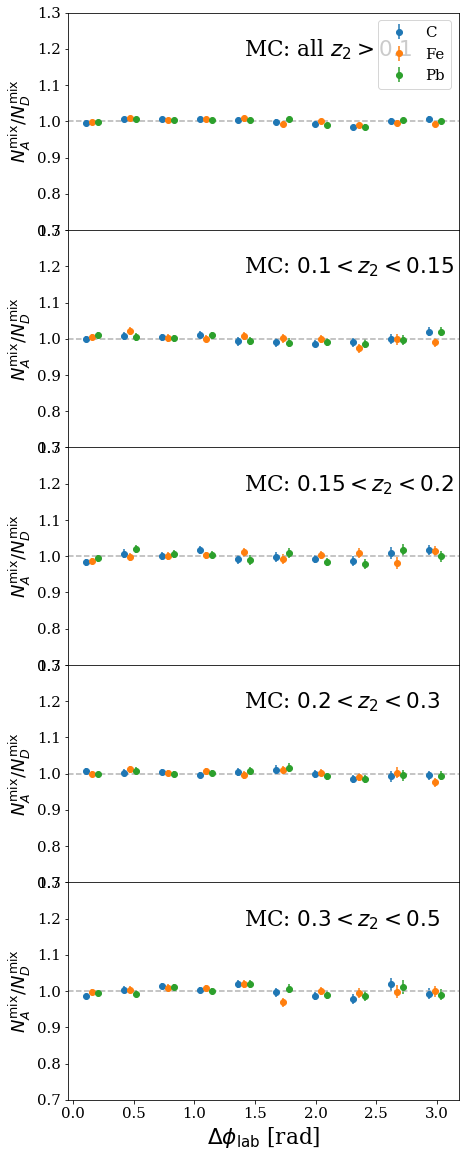

0.07841603842023778
0.12624902250052733
0.14610284715579117
0.06108393115553543
0.08193493053597833
0.08907248094440683
0.06462568596648599
0.09831888460711193
0.11601471175324604
0.06243572558311219
0.11958049025079126
0.13969891535144494
0.07274904550496619
0.1194234516210533
0.12672893098881705


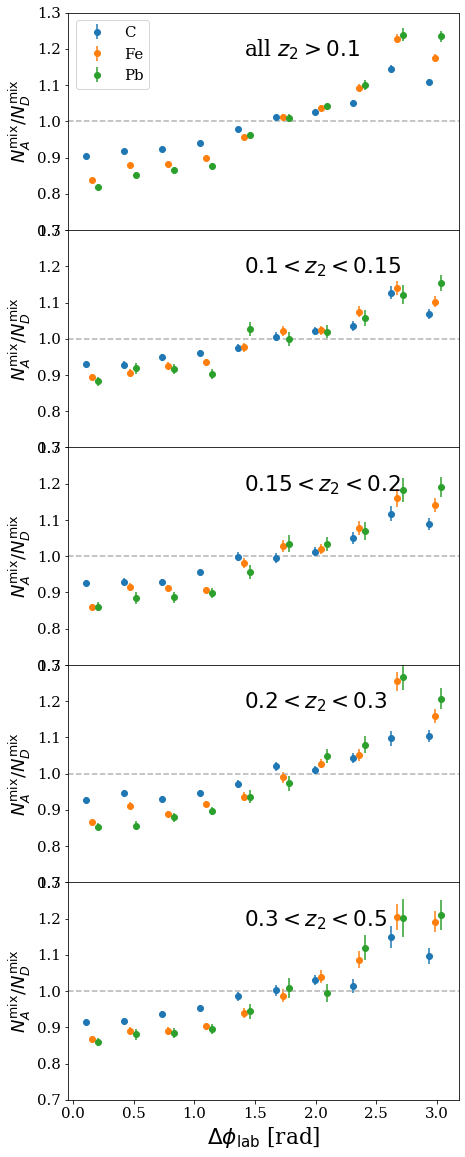

In [210]:
for isMC in True,False:
    #phi lab frame mixing
    partitions = ((0.1,0.15,1),(0.15,0.2,2),(0.2,0.3,3),(0.3,0.5,4))
    fig,axs = plt.subplots(len(partitions)+1,1, figsize=(7,20),sharex='all',sharey='all')
    fig.subplots_adjust(hspace=0)

    yss = []
    xss = []
    dyss = []
    for txt,lbl, q,ax in [["all","all $z_2>0.1$", "h1_z>0.5 and h2_z>0.1", axs[0]]]+\
                    [[f"{mn}<z2<{mx}",f"${mn}<z_2<{mx}$", f"h1_z>0.5 and h2_z>{mn} and h2_z<{mx}",axs[i]] \
                           for mn,mx,i in partitions]:
        xoffset=0.05
        plt.sca(ax)
        ys = []
        xs = []
        dys = []
        for a,color,offsetX in zip('C Fe Pb'.split(),"tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,3)):
            if not isMC:
                mixed_A = dfs_mixed[a+"_2pi"].query(q)
                mixed_D = dfs_mixed["D_"+a+"_2pi"].query(q)
            else:
                mixed_A = dfs_mixed["MC_" + a+"_2pi"].query(q)
                mixed_D = dfs_mixed["MC_D2_2pi"].query(q)
            bins = 10; rang=(0,np.pi);xvar = 'abs(diff_phi_lab)'

            x,y,dy = correlation_plots.plot_uncertainty_from_mixed(mixed_A,mixed_D,bins=bins,
                   label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
            #print(txt)
            #print(a)
            #print('x,y,dy')
            #for i in range(len(x)):
                #print("%.5f,%.5f,%.5f"%(x[i],y[i],dy[i]))
            ys.append(y)
            xs.append(x)
            dys.append(dy)
        plt.axhline(1, color='0.7',linestyle='--')
        plt.gca().set_ylabel("$N^{\\mathrm{mix}}_A/N^{\\mathrm{mix}}_D$",fontsize='large')
        plt.gca().set_xlabel('$\\Delta\\phi_{\\mathrm{lab}}$ [rad]')
        if isMC:
            lbl = "MC: " +lbl
        plt.text(0.45, .8, lbl, fontsize='x-large', transform = plt.gca().transAxes)
        plt.gca().set_ylim(0.7,1.3)
        xss.append(xs)
        yss.append(ys)
        dyss.append(dys)

    for xs,ys,dys in zip(xss,yss,dyss):
        for x,y,dy in zip(xs,ys,dys):
            print(np.sqrt(np.mean((y-1)**2)))

    axs[0].legend()
    plt.show()

UndefinedVariableError: name 'diff_phi_lab' is not defined

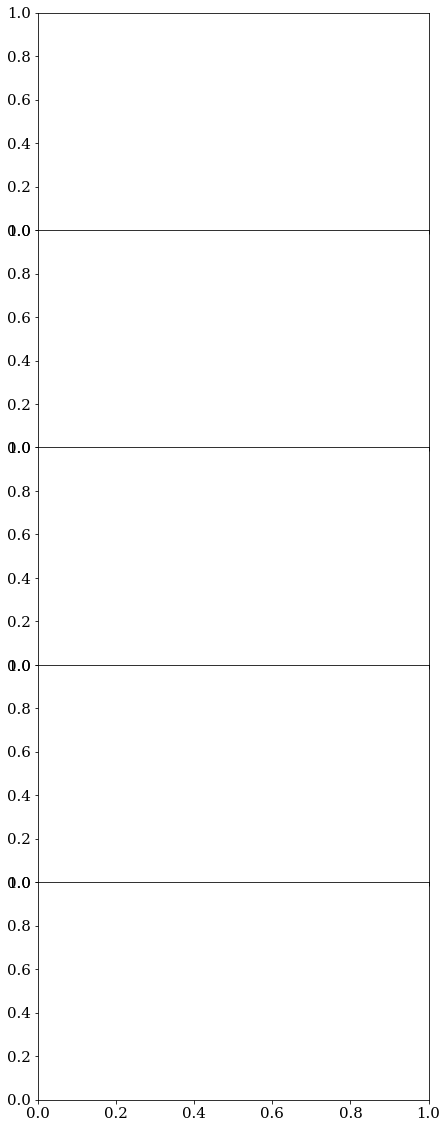

In [212]:
#phi lab frame mixing
partitions = ((0.1,0.15,1),(0.15,0.2,2),(0.2,0.3,3),(0.3,0.5,4))
fig,axs = plt.subplots(len(partitions)+1,1, figsize=(7,20),sharex='all',sharey='all')
fig.subplots_adjust(hspace=0)

yss = []
xss = []
dyss = []
for txt,lbl, q,ax in [["all","all $z_2>0.1$", "h1_z>0.5 and h2_z>0.1", axs[0]]]+\
                [[f"{mn}<z2<{mx}",f"${mn}<z_2<{mx}$", f"h1_z>0.5 and h2_z>{mn} and h2_z<{mx}",axs[i]] \
                       for mn,mx,i in partitions]:
    xoffset=0.05
    plt.sca(ax)
    ys = []
    xs = []
    dys = []
    for a,color,offsetX in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,3)):
        data = dfs_data[a+"_2pi"].query(q)
        
        mc = dfs_data["MC_" + a +"_2pi"].query(q)

        x,y,dy = correlation_plots.plot_uncertainty_from_mixed(data,mc,bins=bins,
               label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
        ys.append(y)
        xs.append(x)
        dys.append(dy)
    plt.axhline(1, color='0.7',linestyle='--')
    plt.gca().set_ylabel("$N^{\\mathrm{data}}/N^{\\mathrm{mc}}$",fontsize='large')
    plt.gca().set_xlabel('$\\Delta\\phi_{\\mathrm{lab}}$ [rad]')
    if isMC:
        lbl = "MC: " +lbl
    plt.text(0.45, .8, lbl, fontsize='x-large', transform = plt.gca().transAxes)
    plt.gca().set_ylim(0.7,1.3)
    xss.append(xs)
    yss.append(ys)
    dyss.append(dys)

for xs,ys,dys in zip(xss,yss,dyss):
    for x,y,dy in zip(xs,ys,dys):
        print(np.sqrt(np.mean((y-1)**2)))

axs[0].legend()
plt.show()

0.5783031424778066
0.5191365944022529
0.48182924474455147
0.4633059395909644
0.3656091696576348
0.3236516710466951
0.30776405149860225
0.301062893597498
0.4390974926195819
0.38803131764531956
0.36628991909920294
0.3504138976541868
0.5207658737214731
0.47736011531069983
0.438446960234217
0.4276082538055923
0.5929380954711981
0.5460299252323426
0.5240697525223683
0.4923145392346502
0.6388717998602513
0.6101488255643387
0.570062001344628
0.55981368702475
0.6874370687920063
0.6420648652558614
0.6164500320561141
0.6242523140808662
0.7441119954528285
0.7016157283389338
0.6751606460715981
0.654113898262453
0.8045076701356991
0.7612206019117136
0.7397871377852997
0.7365332156700481
0.8600421573656418
0.8228941144844151
0.7887677070653526
0.8032099340897667


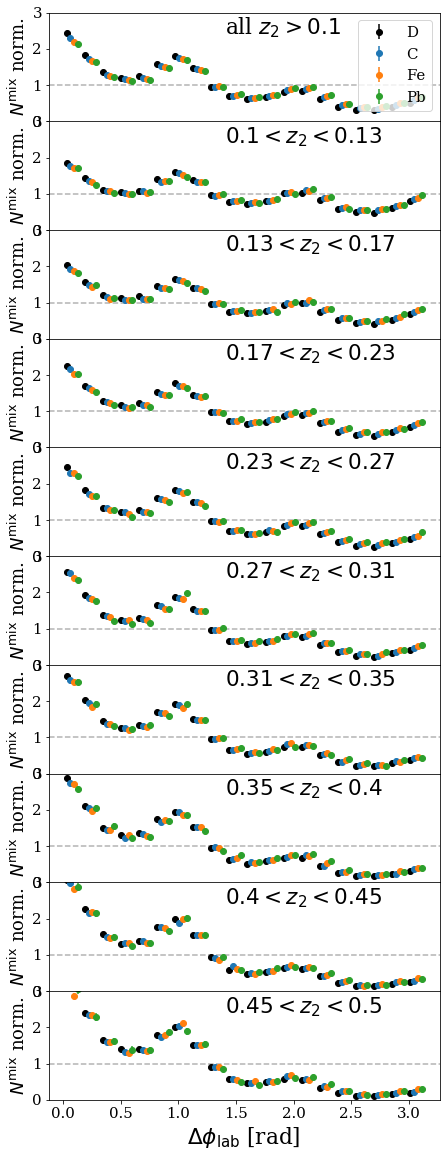

In [203]:
#phi lab frame mixing

imp.reload(correlation_plots)
partitions = ((0.1,0.13,1),(0.13,0.17,2),(0.17,0.23,3),
              (0.23,0.27,4),(0.27,0.31,5),(0.31,0.35,6),(0.35,0.4,7),(0.40,0.45,8),(0.45,0.5,9))
fig,axs = plt.subplots(len(partitions)+1,1, figsize=(7,20),sharex='all',sharey='all')
fig.subplots_adjust(hspace=0)

yss = []
xss = []
dyss = []
for txt,lbl, q,ax in [["all","all $z_2>0.1$", "h1_z>0.5 and h2_z>0.1", axs[0]]]+\
                [[f"{mn}<z2<{mx}",f"${mn}<z_2<{mx}$", f"h1_z>0.5 and h2_z>{mn} and h2_z<{mx}",axs[i]] \
                       for mn,mx,i in partitions]:
    xoffset=0.05
    plt.sca(ax)
    ys = []
    xs = []
    dys = []
    for a,color,offsetX in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,4)):
        mixed_A = dfs_mixed[a+"_2pi"].query(q)
        mixed_D = None# dfs_mixed["D_"+a].query(q)

        bins = 20; rang=(0,np.pi);xvar = 'abs(diff_phi_lab)'

        x,y,dy = correlation_plots.plot_uncertainty_from_mixed(mixed_A,mixed_D,bins=bins,
               label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
        #print(txt)
        #print(a)
        #print('x,y,dy')
        #for i in range(len(x)):
            #print("%.5f,%.5f,%.5f"%(x[i],y[i],dy[i]))
        ys.append(y)
        xs.append(x)
        dys.append(dy)
    plt.axhline(1, color='0.7',linestyle='--')
    plt.gca().set_ylabel("$N^{\\mathrm{mix}}$ norm.",fontsize='large')
    plt.gca().set_xlabel('$\\Delta\\phi_{\\mathrm{lab}}$ [rad]')
    plt.text(0.45, .8, lbl, fontsize='x-large', transform = plt.gca().transAxes)
    plt.gca().set_ylim(0,3)
    xss.append(xs)
    yss.append(ys)
    dyss.append(dys)

for xs,ys,dys in zip(xss,yss,dyss):
    for x,y,dy in zip(xs,ys,dys):
        print(np.sqrt(np.mean((y-1)**2)))
    
axs[0].legend()
plt.show()

all
C
x,y,dy
0.15708,1.04053,0.01358
0.47124,1.03313,0.01312
0.78540,1.03025,0.01293
1.09956,1.03138,0.01243
1.41372,0.98020,0.01111
1.72788,1.01212,0.01146
2.04204,0.97957,0.01107
2.35619,0.97141,0.01073
2.67035,0.97711,0.01046
2.98451,0.94431,0.00945
all
Fe
x,y,dy
0.15708,1.07047,0.01395
0.47124,1.06919,0.01364
0.78540,1.01201,0.01269
1.09956,0.98932,0.01184
1.41372,0.99327,0.01134
1.72788,0.97978,0.01096
2.04204,0.99879,0.01143
2.35619,0.97795,0.01095
2.67035,0.95992,0.01034
2.98451,0.94930,0.00967
all
Pb
x,y,dy
0.15708,1.04715,0.01455
0.47124,1.06602,0.01443
0.78540,1.02305,0.01378
1.09956,0.99729,0.01286
1.41372,0.99953,0.01234
1.72788,1.02039,0.01245
2.04204,0.97527,0.01198
2.35619,0.95524,0.01154
2.67035,0.96865,0.01129
2.98451,0.94741,0.01053


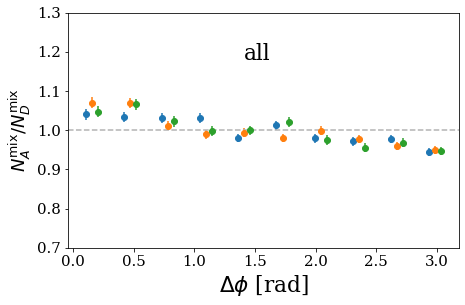

pi+pi+
C
x,y,dy
0.15708,1.02344,0.01663
0.47124,1.01658,0.01625
0.78540,1.03163,0.01641
1.09956,1.02555,0.01575
1.41372,0.97659,0.01431
1.72788,1.02324,0.01517
2.04204,0.99118,0.01476
2.35619,0.97423,0.01424
2.67035,0.97757,0.01378
2.98451,0.95999,0.01277
pi+pi+
Fe
x,y,dy
0.15708,1.05455,0.01718
0.47124,1.05228,0.01698
0.78540,0.99344,0.01576
1.09956,0.98378,0.01499
1.41372,1.00638,0.01486
1.72788,0.97727,0.01423
2.04204,1.00239,0.01502
2.35619,0.97752,0.01438
2.67035,0.98523,0.01408
2.98451,0.96716,0.01307
pi+pi+
Pb
x,y,dy
0.15708,1.03946,0.01827
0.47124,1.04883,0.01815
0.78540,0.99354,0.01710
1.09956,1.00169,0.01662
1.41372,1.00767,0.01629
1.72788,1.00187,0.01619
2.04204,0.98633,0.01601
2.35619,0.96347,0.01553
2.67035,0.99974,0.01554
2.98451,0.95742,0.01426


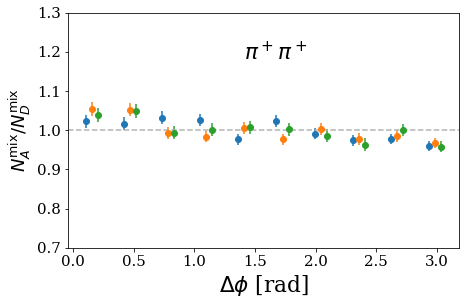

pi+pi-
C
x,y,dy
0.15708,1.06523,0.02766
0.47124,1.05510,0.02635
0.78540,1.02911,0.02507
1.09956,1.03821,0.02418
1.41372,0.97367,0.02080
1.72788,0.99752,0.02125
2.04204,0.96675,0.02036
2.35619,0.97494,0.01981
2.67035,0.98115,0.01939
2.98451,0.91832,0.01708
pi+pi-
Fe
x,y,dy
0.15708,1.08861,0.02778
0.47124,1.10171,0.02722
0.78540,1.05924,0.02587
1.09956,0.98815,0.02272
1.41372,0.95666,0.02056
1.72788,0.98803,0.02100
2.04204,1.01381,0.02189
2.35619,0.96601,0.01993
2.67035,0.91461,0.01781
2.98451,0.92317,0.01742
pi+pi-
Pb
x,y,dy
0.15708,1.03913,0.02771
0.47124,1.09215,0.02804
0.78540,1.08006,0.02779
1.09956,1.00382,0.02456
1.41372,0.97837,0.02235
1.72788,1.05789,0.02379
2.04204,0.95365,0.02164
2.35619,0.93353,0.02038
2.67035,0.94170,0.01974
2.98451,0.91971,0.01871


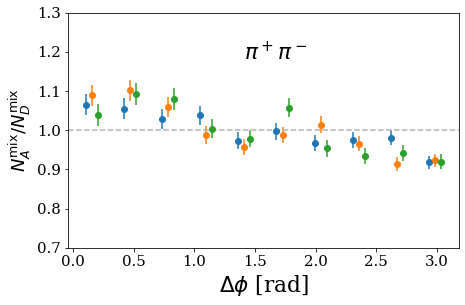

pi-pi+
C
x,y,dy
0.15708,1.06699,0.05034
0.47124,1.05618,0.04770
0.78540,1.00966,0.04428
1.09956,0.99534,0.04099
1.41372,0.99981,0.03939
1.72788,1.02640,0.03928
2.04204,0.91358,0.03423
2.35619,0.95100,0.03583
2.67035,0.98415,0.03648
2.98451,0.99688,0.03386
pi-pi+
Fe
x,y,dy
0.15708,1.10370,0.05266
0.47124,1.09560,0.05025
0.78540,0.97869,0.04307
1.09956,1.00394,0.04203
1.41372,1.03001,0.04144
1.72788,0.96112,0.03620
2.04204,0.97149,0.03784
2.35619,0.99689,0.03930
2.67035,0.93633,0.03550
2.98451,0.92222,0.03146
pi-pi+
Pb
x,y,dy
0.15708,1.15268,0.05954
0.47124,1.12588,0.05477
0.78540,1.01893,0.05005
1.09956,0.98936,0.04472
1.41372,0.98769,0.04255
1.72788,0.98563,0.04093
2.04204,0.96271,0.04034
2.35619,0.92735,0.03881
2.67035,0.91089,0.03732
2.98451,0.93889,0.03514


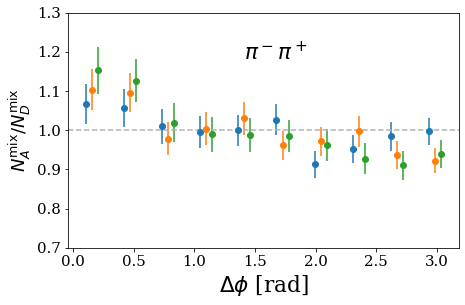

pi-pi-
C
x,y,dy
0.15708,1.09051,0.08793
0.47124,1.08813,0.07921
0.78540,1.02363,0.07363
1.09956,1.15302,0.07934
1.41372,1.01649,0.05959
1.72788,0.91657,0.04841
2.04204,1.02994,0.05488
2.35619,0.93380,0.04753
2.67035,0.91332,0.04547
2.98451,0.83460,0.03476
pi-pi-
Fe
x,y,dy
0.15708,1.27903,0.10750
0.47124,1.08104,0.07884
0.78540,1.08646,0.07835
1.09956,1.07389,0.07454
1.41372,0.94781,0.05508
1.72788,0.93160,0.04937
2.04204,0.85476,0.04404
2.35619,0.95551,0.05057
2.67035,0.92293,0.04622
2.98451,0.86697,0.03891
pi-pi-
Pb
x,y,dy
0.15708,1.29784,0.11008
0.47124,1.16072,0.09118
0.78540,1.23486,0.09169
1.09956,0.94234,0.06555
1.41372,0.98932,0.05993
1.72788,0.95095,0.05396
2.04204,0.89058,0.05074
2.35619,0.90977,0.05089
2.67035,0.76989,0.04137
2.98451,0.85373,0.04078


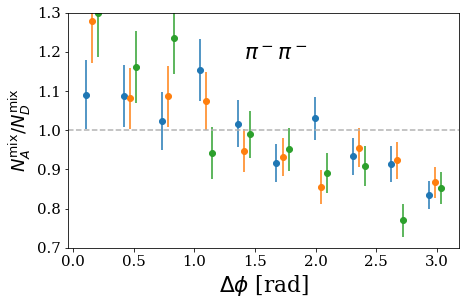

0.1<z2<0.2
C
x,y,dy
0.15708,1.05768,0.02041
0.47124,1.04343,0.01941
0.78540,1.03945,0.01945
1.09956,1.02745,0.01869
1.41372,0.99477,0.01722
1.72788,0.99062,0.01695
2.04204,0.97954,0.01676
2.35619,0.95634,0.01595
2.67035,0.96829,0.01589
2.98451,0.94244,0.01479
0.1<z2<0.2
Fe
x,y,dy
0.15708,1.08503,0.02085
0.47124,1.08751,0.02045
0.78540,1.01850,0.01893
1.09956,0.97585,0.01745
1.41372,0.99652,0.01719
1.72788,0.97058,0.01636
2.04204,0.99565,0.01711
2.35619,0.96627,0.01628
2.67035,0.96707,0.01598
2.98451,0.93701,0.01483
0.1<z2<0.2
Pb
x,y,dy
0.15708,1.02239,0.02043
0.47124,1.08148,0.02105
0.78540,1.01823,0.01988
1.09956,1.01341,0.01930
1.41372,1.00717,0.01830
1.72788,1.02127,0.01848
2.04204,0.96967,0.01764
2.35619,0.94158,0.01677
2.67035,0.97655,0.01708
2.98451,0.94825,0.01612


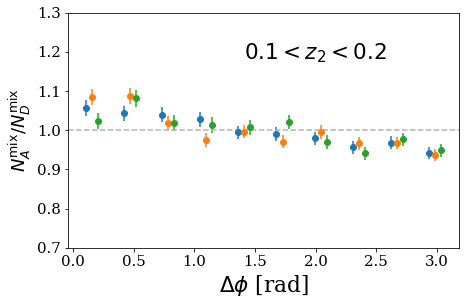

0.2<z2<0.3
C
x,y,dy
0.15708,1.03118,0.02541
0.47124,1.01430,0.02441
0.78540,1.00948,0.02379
1.09956,1.01857,0.02298
1.41372,0.99224,0.02129
1.72788,1.02037,0.02173
2.04204,0.99104,0.02129
2.35619,1.00953,0.02128
2.67035,0.97897,0.01975
2.98451,0.93434,0.01747
0.2<z2<0.3
Fe
x,y,dy
0.15708,1.05200,0.02579
0.47124,1.02644,0.02432
0.78540,0.99678,0.02368
1.09956,1.02443,0.02349
1.41372,0.96773,0.02074
1.72788,0.99660,0.02116
2.04204,0.99321,0.02153
2.35619,1.01262,0.02167
2.67035,0.96085,0.01943
2.98451,0.96933,0.01856
0.2<z2<0.3
Pb
x,y,dy
0.15708,1.07651,0.02837
0.47124,1.05513,0.02716
0.78540,1.03467,0.02648
1.09956,0.99031,0.02424
1.41372,0.99022,0.02331
1.72788,1.03094,0.02376
2.04204,0.96452,0.02248
2.35619,0.93860,0.02164
2.67035,0.96758,0.02132
2.98451,0.95152,0.01979


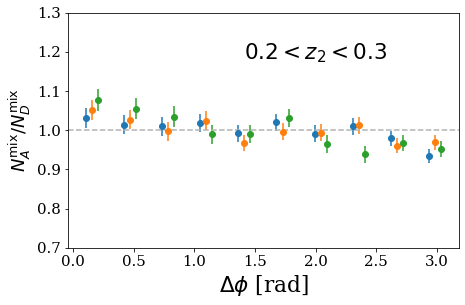

0.3<z2<0.4
C
x,y,dy
0.15708,1.00826,0.03484
0.47124,1.02771,0.03511
0.78540,0.99665,0.03281
1.09956,1.05504,0.03306
1.41372,0.92689,0.02664
1.72788,1.07893,0.03201
2.04204,0.99963,0.02921
2.35619,0.94557,0.02693
2.67035,1.02246,0.02843
2.98451,0.93886,0.02340
0.3<z2<0.4
Fe
x,y,dy
0.15708,1.01925,0.03533
0.47124,1.04685,0.03586
0.78540,1.02272,0.03423
1.09956,0.97946,0.03073
1.41372,1.01473,0.03016
1.72788,0.99010,0.02875
2.04204,1.00430,0.02998
2.35619,0.97358,0.02840
2.67035,0.96717,0.02689
2.98451,0.98184,0.02513
0.3<z2<0.4
Pb
x,y,dy
0.15708,0.99738,0.03856
0.47124,0.98838,0.03735
0.78540,1.02129,0.03815
1.09956,0.96315,0.03331
1.41372,0.97637,0.03213
1.72788,1.02836,0.03346
2.04204,0.99465,0.03268
2.35619,1.03753,0.03392
2.67035,1.00689,0.03106
2.98451,0.98601,0.02848


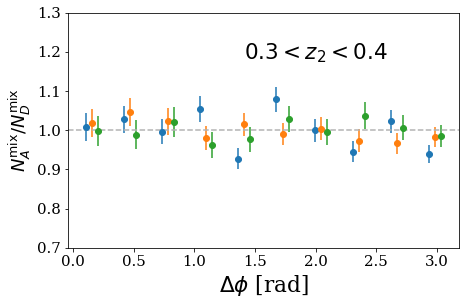

0.4<z2<0.5
C
x,y,dy
0.15708,1.00966,0.04821
0.47124,0.94165,0.04323
0.78540,1.07125,0.04880
1.09956,1.07072,0.04617
1.41372,0.99306,0.03928
1.72788,0.95847,0.03723
2.04204,0.92763,0.03605
2.35619,1.00960,0.03926
2.67035,1.00044,0.03645
2.98451,1.01752,0.03416
0.4<z2<0.5
Fe
x,y,dy
0.15708,0.99994,0.04833
0.47124,1.05875,0.05165
0.78540,0.98536,0.04498
1.09956,1.02043,0.04336
1.41372,1.02444,0.04154
1.72788,0.95558,0.03706
2.04204,0.98602,0.03965
2.35619,0.99484,0.03935
2.67035,0.98024,0.03647
2.98451,0.99441,0.03442
0.4<z2<0.5
Pb
x,y,dy
0.15708,1.05886,0.05882
0.47124,1.00602,0.05367
0.78540,0.95293,0.04917
1.09956,0.98311,0.04737
1.41372,1.01018,0.04584
1.72788,1.03557,0.04692
2.04204,1.01033,0.04567
2.35619,0.95479,0.04188
2.67035,0.95317,0.03936
2.98451,1.03503,0.04062


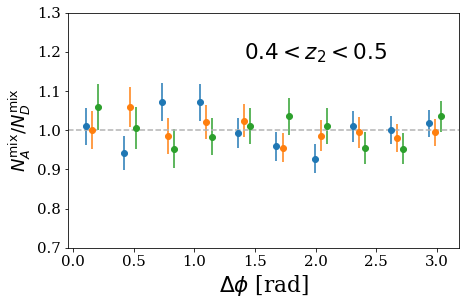

In [18]:
for txt,lbl, q in [\
                ["all","all", "h1_z>0.5 and h2_z>0.1"],
                ["pi+pi+","$\\pi^+\\pi^+$", "h1_z>0.5 and h2_z>0.1 and h1_pid==211 and h2_pid==211"],
                ["pi+pi-","$\\pi^+\\pi^-$", "h1_z>0.5 and h2_z>0.1 and h1_pid==211 and h2_pid==-211"],
                ["pi-pi+","$\\pi^-\\pi^+$", "h1_z>0.5 and h2_z>0.1 and h1_pid==-211 and h2_pid==211"],
                ["pi-pi-","$\\pi^-\\pi^-$", "h1_z>0.5 and h2_z>0.1 and h1_pid==-211 and h2_pid==-211"],
                ] + [[f"{mn}<z2<{mx}",f"${mn}<z_2<{mx}$", f"h1_z>0.5 and h2_z>{mn} and h2_z<{mx}"] \
                       for mn,mx in ((0.1,0.2),(0.2,0.3),(0.3,0.4),(0.4,0.5))]:
    xoffset=0.05
    for a,color,offsetX in zip('C Fe Pb'.split(),"tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,3)):
        mixed_A = dfs_mixed[a].query(q)
        mixed_D = dfs_mixed["D_"+a].query(q)

        bins = 10; rang=(0,np.pi);xvar = 'abs(diff_phi_cm)'

        x,y,dy = correlation_plots.plot_uncertainty_from_mixed(mixed_A,mixed_D,bins=bins,
               label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
        print(txt)
        print(a)
        print('x,y,dy')
        for i in range(len(x)):
            print("%.5f,%.5f,%.5f"%(x[i],y[i],dy[i]))
    plt.axhline(1, color='0.7',linestyle='--')
    plt.gca().set_ylabel("$N^{\\mathrm{mix}}_A/N^{\\mathrm{mix}}_D$",fontsize='large')
    plt.gca().set_xlabel('$\\Delta\\phi$ [rad]')
    plt.text(0.45, .8, lbl, fontsize='x-large', transform = plt.gca().transAxes)
    plt.gca().set_ylim(0.7,1.3)
    plt.show()
    

In [151]:
def allCorr(tag2='', samples = dfs_mixed, suptitle=None,q = "h1_z>0.5 and h2_z>0.1"):
    imp.reload(correlation_plots)
    for xlbl,tag, xvar,rang,bins,xoffset in [['$\\Delta\\phi$ [rad]','dphi','abs(diff_phi_cm)',(0,np.pi),5,.05],
                            ['$z_2$', 'z2','h2_z',(.1,0.5),5,.01]]:
        fig,axs  = plt.subplots(4,1, figsize=(7,14),sharex='all',sharey='all')
        fig.subplots_adjust(hspace=0)
        for query,lbl,ax in zip(('h1_pid==211 and h2_pid==211','h1_pid==211 and h2_pid==-211',
                            'h1_pid==-211 and h2_pid==211', 'h1_pid==-211 and h2_pid==-211'), r"$\pi^+\pi^+$ $\pi^+\pi^-$ $\pi^-\pi^+$ $\pi^-\pi^-$".split(),
                            axs):
            
            samples = {**samples, 
                       'avg': pd.concat([samples[a] for a in 'C Fe Pb'.split()]),
                       'D_avg': pd.concat([samples['D_'+a] for a in 'C Fe Pb'.split()])
                      }
            for a,color,offsetX in zip('C Fe Pb avg'.split(),"tab:blue tab:orange tab:green 0.5".split(),np.linspace(-xoffset,xoffset,4)):
                mixed_A = samples[a].query(q)
                mixed_D = samples["D_"+a].query(q)
                plt.sca(ax)
                x,y,dy = correlation_plots.plot_uncertainty_from_mixed(mixed_A.query(query),mixed_D.query(query),bins=bins,
                       label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
                #print an estimate of the systematic error
                if a=='avg':
                    print(np.sqrt(sum((y-1)**2/dy**2)/sum(1/dy**2)), 
                          np.sqrt(sum(((y-1)**2-dy**2)*(abs(y-1)>dy)/dy**2)/sum(1/dy**2)))
                
            plt.gca().set_ylabel("$M_A/M_D$",fontsize='large')
            plt.gca().set_xlabel(xlbl)
            plt.text(0.45, .8, lbl,fontsize='x-large',transform = ax.transAxes)
            plt.gca().set_ylim(.6,1.4) 
            plt.axhline(1, color='0.7',linestyle='--')
        axs[0].legend()
        if not suptitle is None:
            fig.suptitle(suptitle)
        plt.savefig(image_dir + f"/syst_mixed_R2h_{tag}_{tag2}.pdf",bbox_inches='tight')

0.023019736241721916 0.019447537480217342
0.06686720783864883 0.06408839502627121
0.04168002692042407 0.021997490601418188
0.08615583660836863 0.07297859718965947


/home/sebouh/sidis_tuples/python/correlation_plots.py:299: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[0]/ys[1]*np.sqrt(dys[0]/ys[0],dys[1]/ys[1])
/home/sebouh/sidis_tuples/python/correlation_plots.py:300: RuntimeWarning: invalid value encountered in true_divide
  denom = np.average(y)


nan nan
nan nan
nan nan
nan nan
0.023048086345632275 0.018808614014446303
0.04823571389148823 0.04407380085730271
0.08721942215351305 0.07704827398282944
0.13153278546064281 0.11806774302151102


/home/sebouh/sidis_tuples/python/correlation_plots.py:299: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[0]/ys[1]*np.sqrt(dys[0]/ys[0],dys[1]/ys[1])
/home/sebouh/sidis_tuples/python/correlation_plots.py:300: RuntimeWarning: invalid value encountered in true_divide
  denom = np.average(y)


nan nan
nan nan
nan nan
nan nan
0.023087553522864943 0.006541274272452302
0.012127475049953694 0.0
0.04219131168265201 0.0
0.04471531832340751 0.0


/home/sebouh/sidis_tuples/python/correlation_plots.py:299: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[0]/ys[1]*np.sqrt(dys[0]/ys[0],dys[1]/ys[1])
/home/sebouh/sidis_tuples/python/correlation_plots.py:300: RuntimeWarning: invalid value encountered in true_divide
  denom = np.average(y)


nan nan
nan nan
nan nan
nan nan
0.018211405194888237 0.0
0.04107300236252906 0.00978066624602665
0.034923612223072976 0.0
0.14416660996008324 0.06304535708933179


/home/sebouh/sidis_tuples/python/correlation_plots.py:299: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[0]/ys[1]*np.sqrt(dys[0]/ys[0],dys[1]/ys[1])
/home/sebouh/sidis_tuples/python/correlation_plots.py:300: RuntimeWarning: invalid value encountered in true_divide
  denom = np.average(y)


nan nan
nan nan
nan nan
nan nan


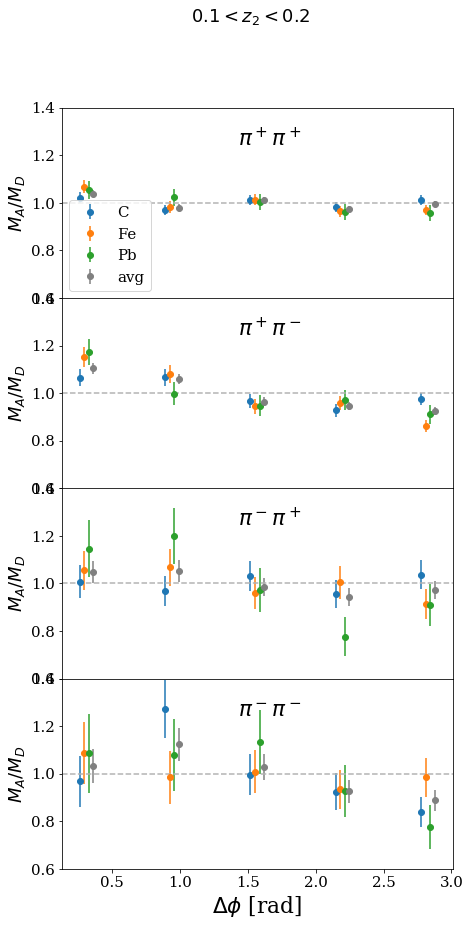

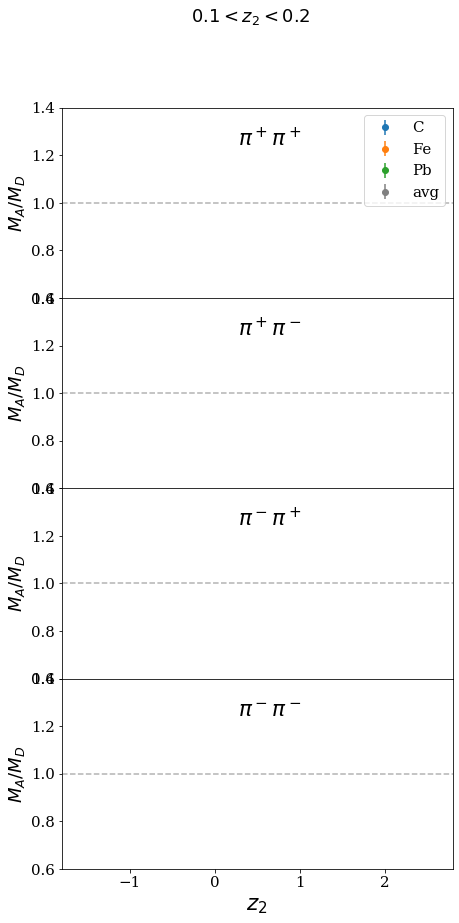

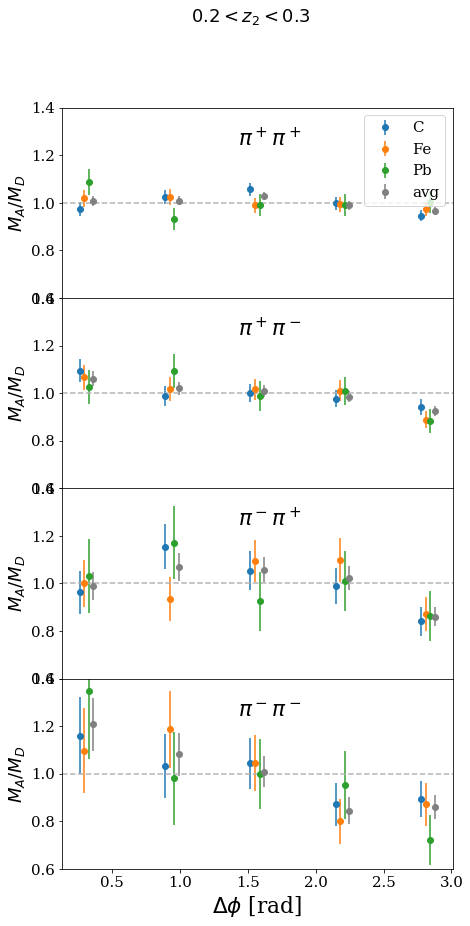

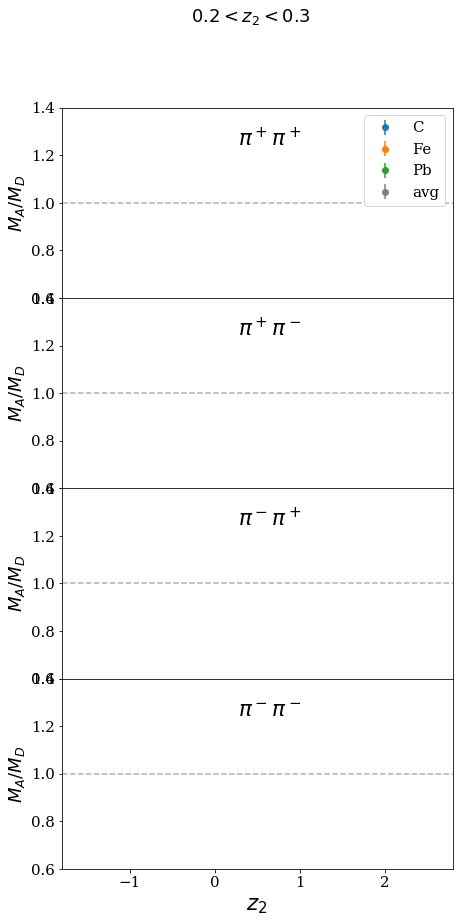

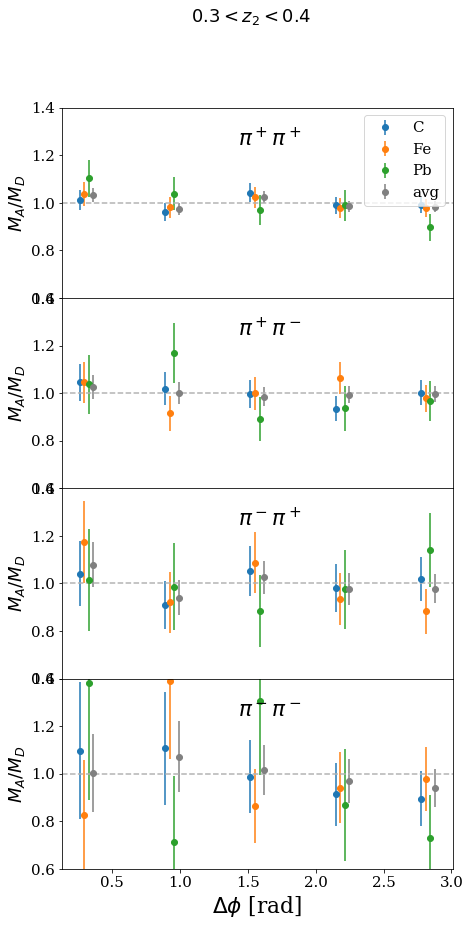

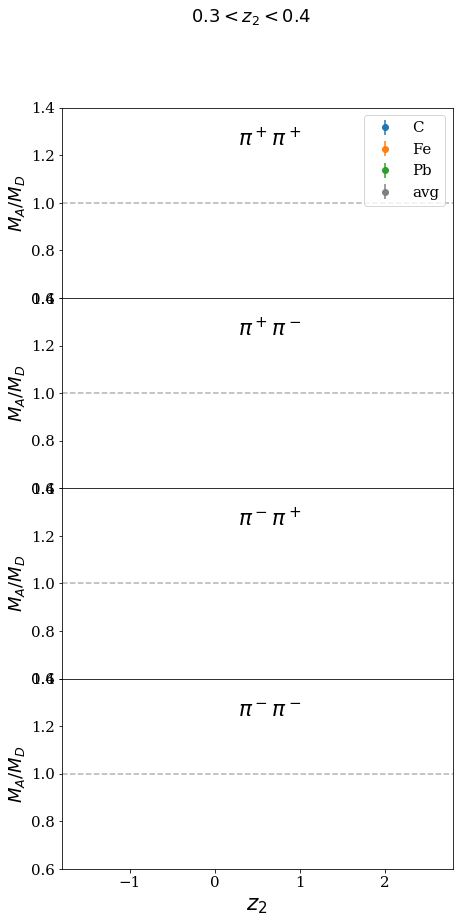

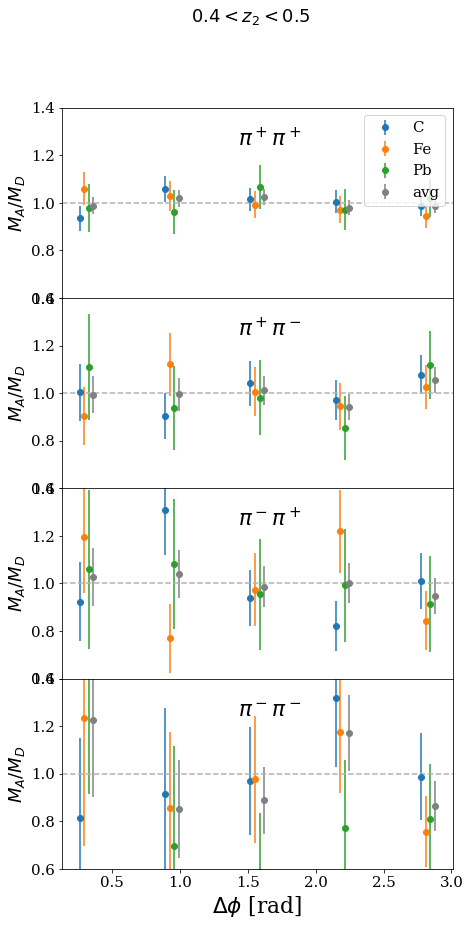

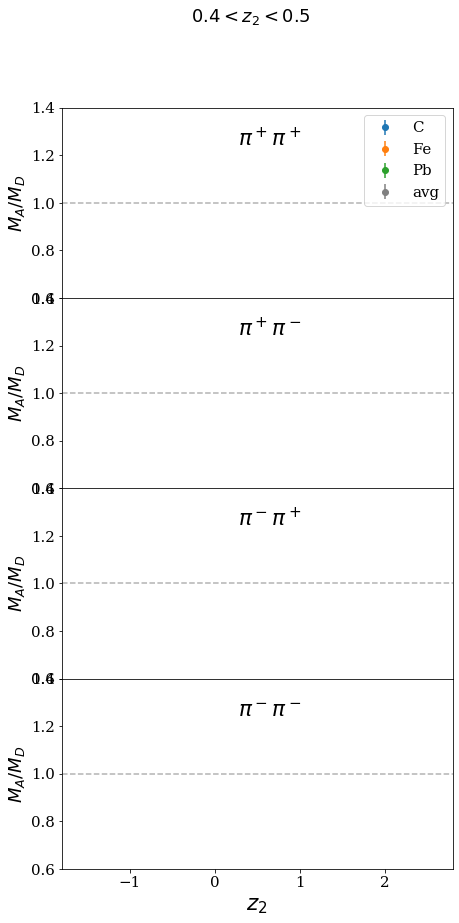

In [152]:
for z2min,z2max in (0.1,0.2),(0.2,0.3),(0.3,0.4),(0.4,0.5):
    allCorr(suptitle=f'${z2min}<z_2<{z2max}$', q=f"h1_z>0.5 and h2_z>{z2min} and h2_z<{z2max}",tag2=f"z2_{z2min}_{z2max}")

0.026052047763706322 0.01942534873238996
0.0532895714159067 0.04706253155750798
0.05341004757418012 0.039651050231728865
0.076998556837455 0.058233815750611956
0.10991781653010912 0.1082513639680526
0.1486429289670978 0.1458995334057791
0.12349497541646524 0.11562988615120158
0.10412965143067665 0.08820840435067101
0.033838832474169016 0.026778727936287036
0.07500038647939072 0.06683743517392637
0.1093484691285373 0.08616051651908431
0.1715468032364523 0.1491805100229427
0.11133941408180881 0.1088769668415023
0.13203462918268685 0.12842918506580164
0.17153969765541122 0.15819097020579356
0.15357034058988922 0.12133050279246588
0.037640561264097414 0.020195790586972604
0.06757120218051287 0.055524981837464855
0.12576032530697662 0.09515163473905433
0.1752849350178244 0.12777505006335893
0.10206685284485796 0.09769481630745402
0.1376440940652195 0.1305628303989268
0.15693514409644704 0.12749757865566144
0.2241463885953325 0.17942305236168446
0.058051529651200626 0.04936551099437353
0.065

/home/sebouh/sidis_tuples/python/correlation_plots.py:300: RuntimeWarning: invalid value encountered in true_divide
  denom = np.average(y)


0.26829078980958826 0.1687917647355811
0.12305734343751802 0.11751921173926805
0.11789184042677843 0.11028903856480612
0.2336226323416288 0.16665095890460732


/home/sebouh/sidis_tuples/python/correlation_plots.py:300: RuntimeWarning: invalid value encountered in true_divide
  denom = np.average(y)


0.3756031239159367 0.28997130263650206


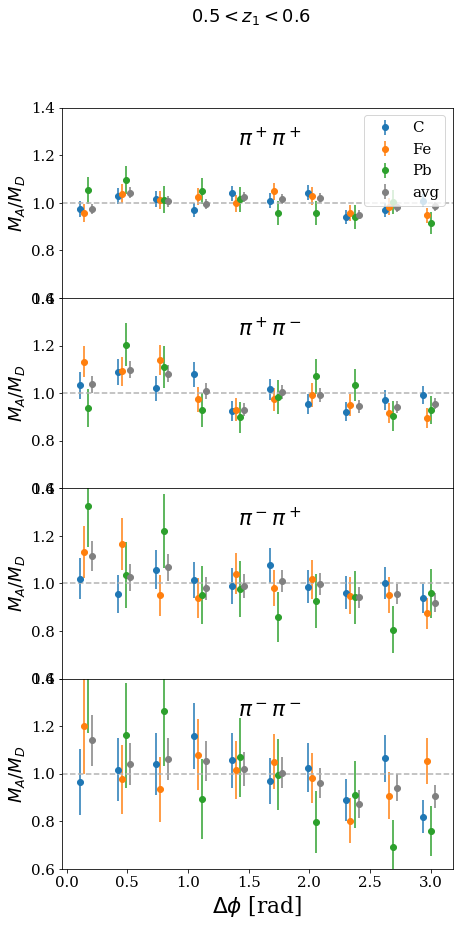

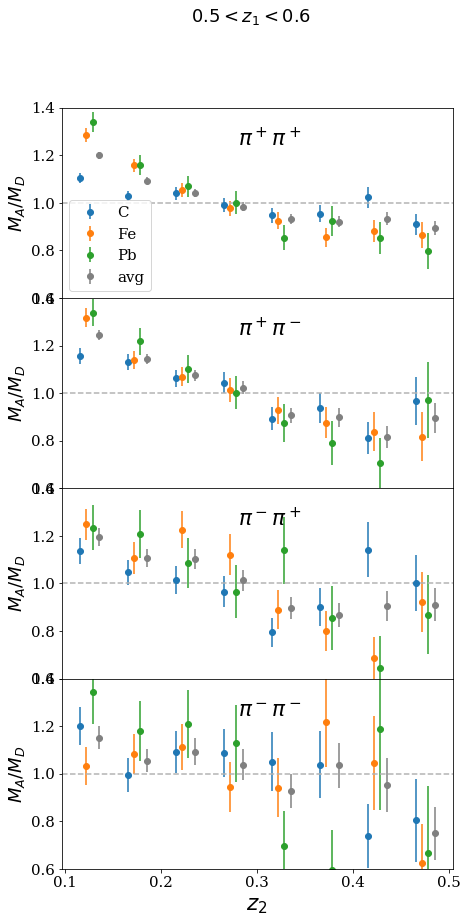

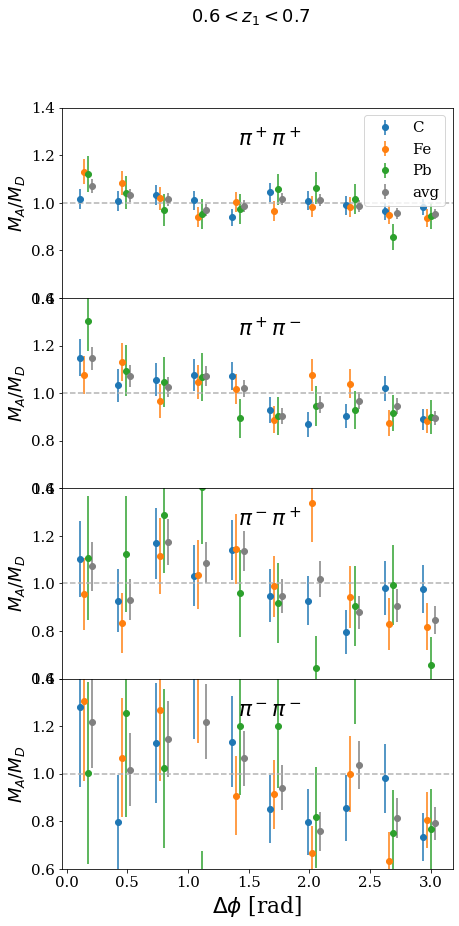

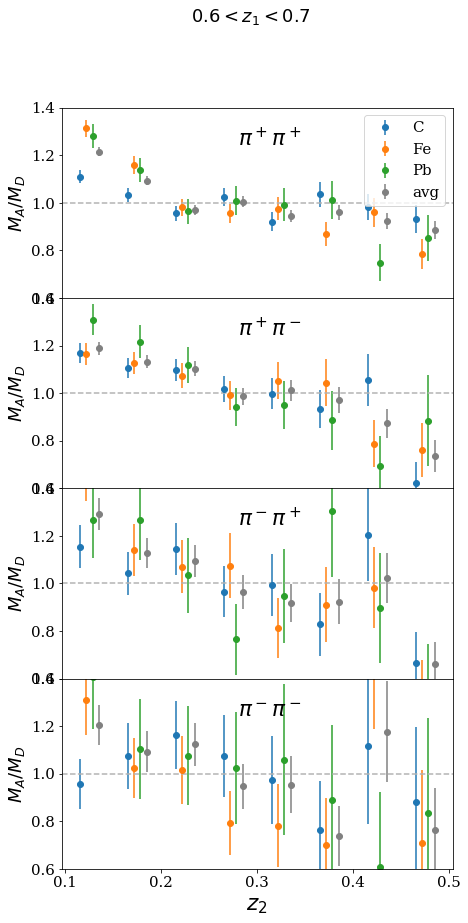

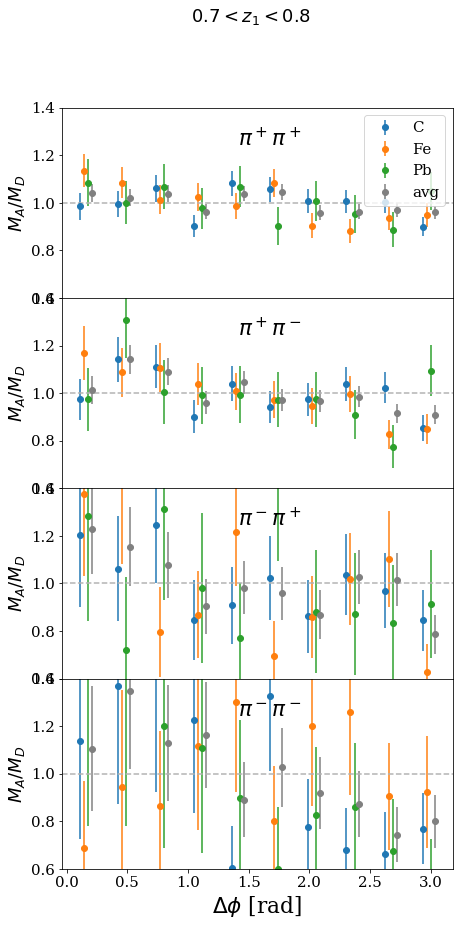

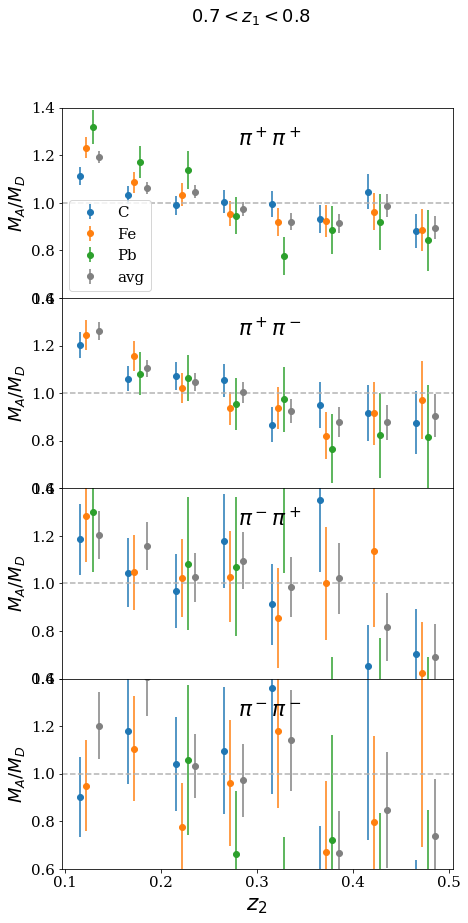

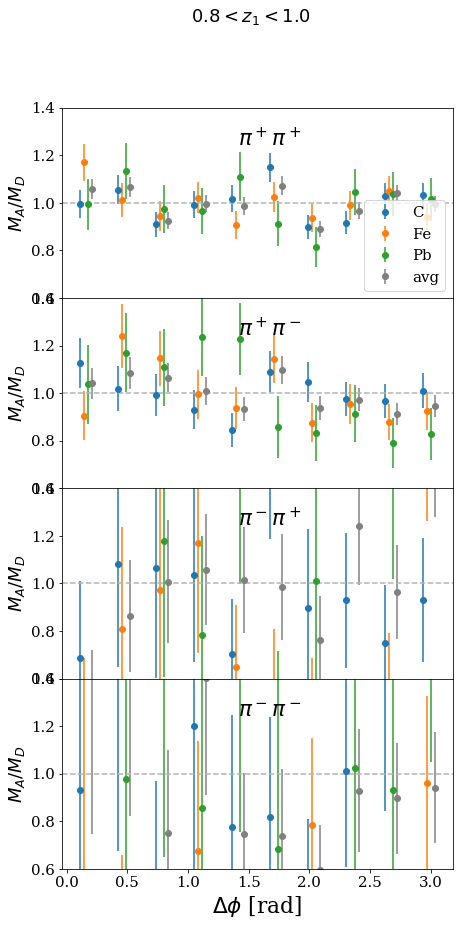

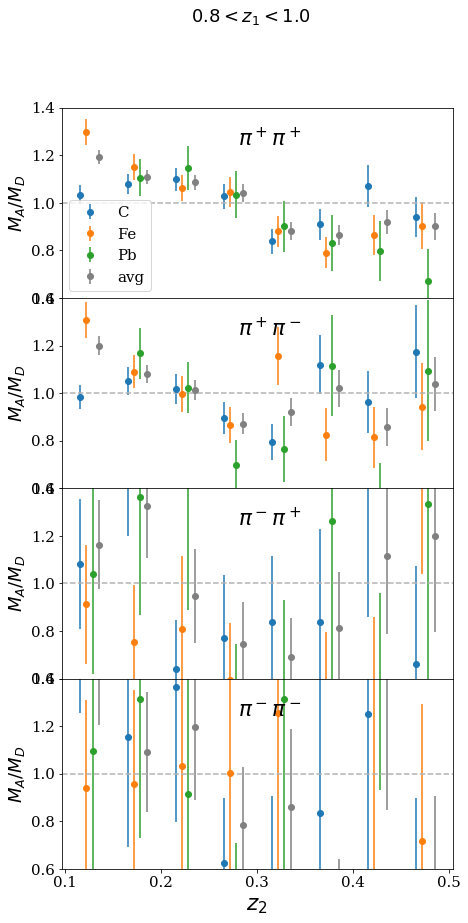

In [150]:
for z1min,z1max in (0.5,0.6),(0.6,0.7),(0.7,0.8),(0.8,1.0):
    allCorr(suptitle=f'${z1min}<z_1<{z1max}$', q=f"h2_z>0.1 and h1_z>{z1min} and h1_z<{z1max}",tag2=f"z1_{z1min}_{z1max}")

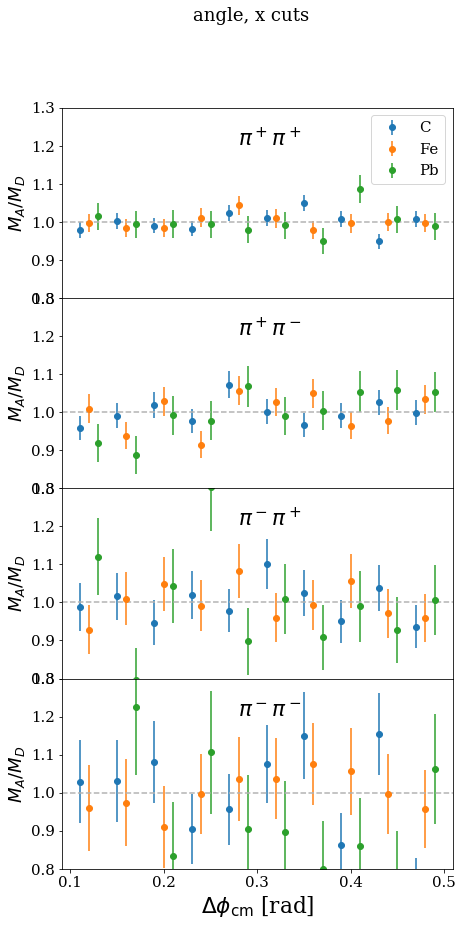

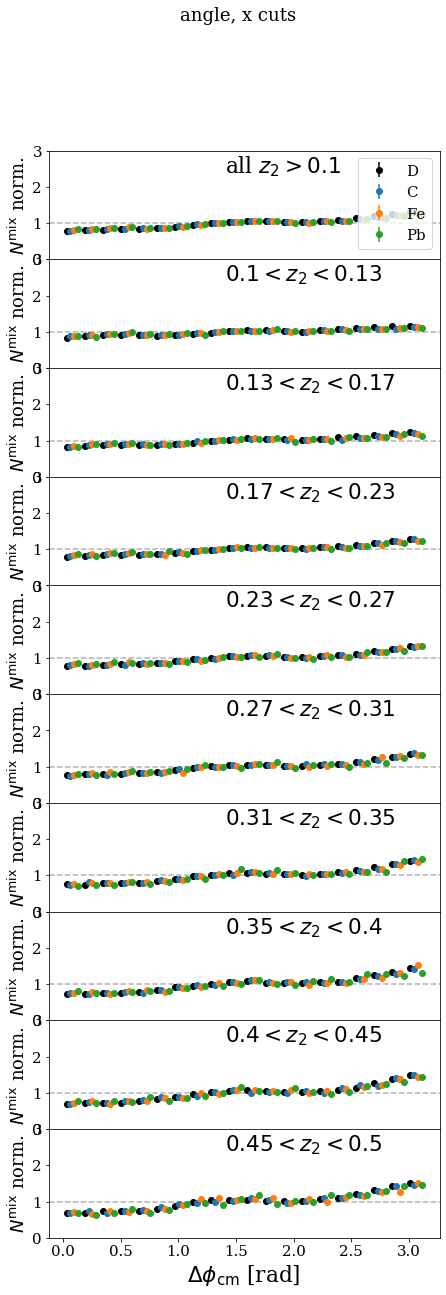

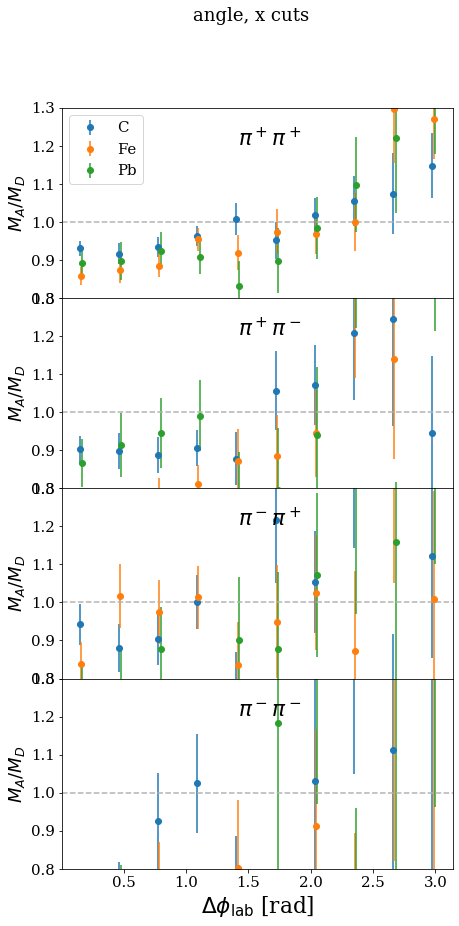

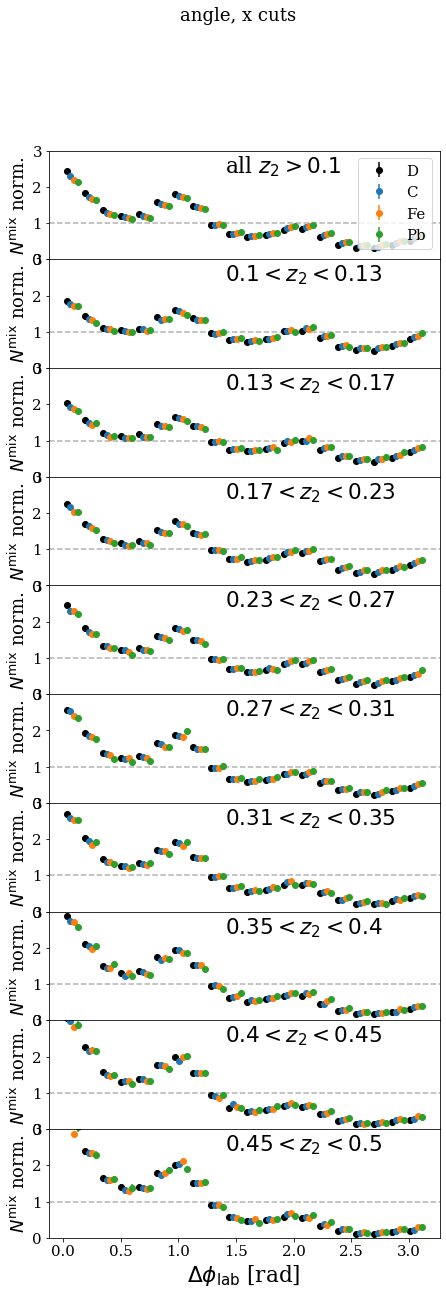

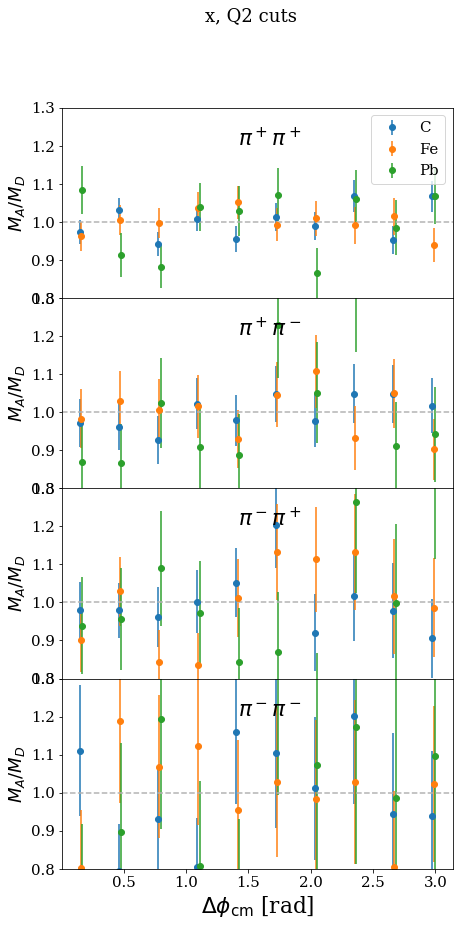

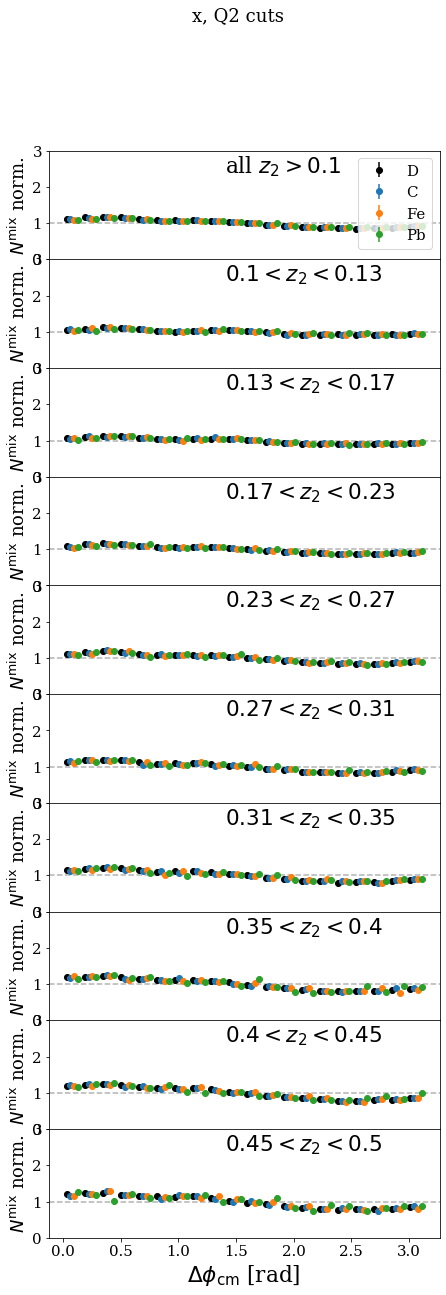

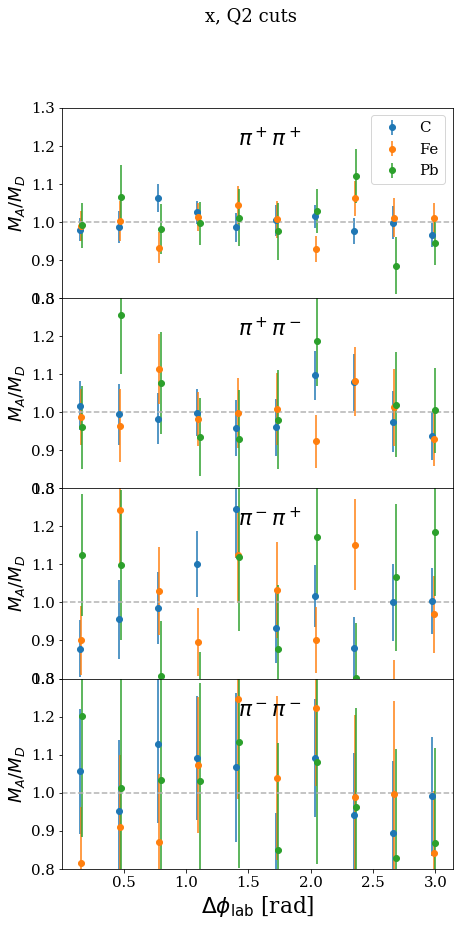

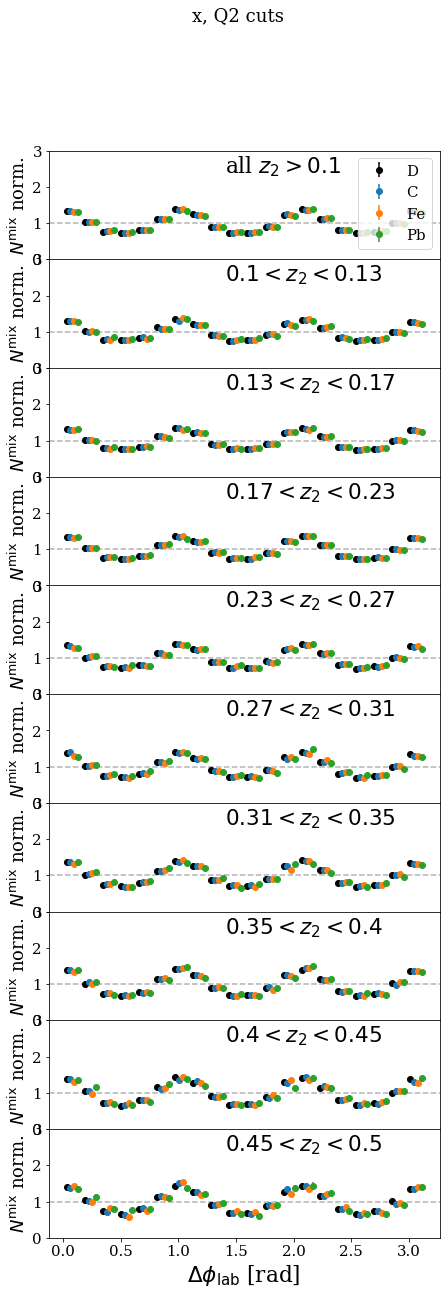

/home/sebouh/sidis_tuples/python/correlation_plots.py:335: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[0]/ys[1]*np.hypot(dys[0]/ys[0],dys[1]/ys[1])


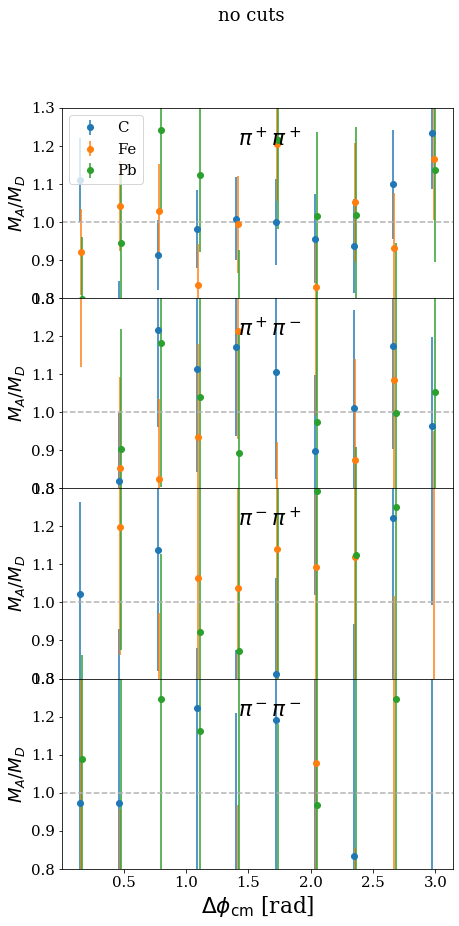

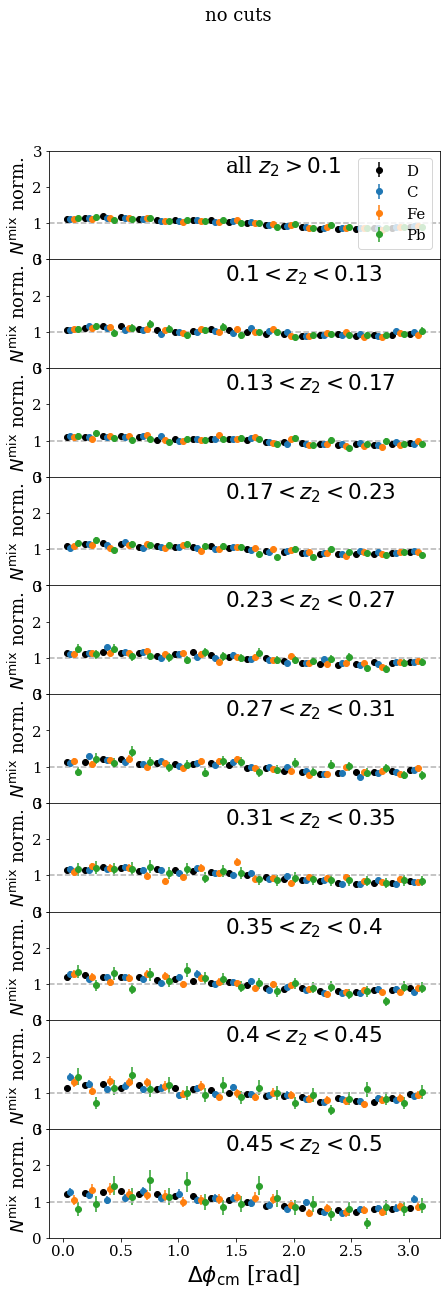

/home/sebouh/sidis_tuples/python/correlation_plots.py:335: RuntimeWarning: invalid value encountered in true_divide
  dy = ys[0]/ys[1]*np.hypot(dys[0]/ys[0],dys[1]/ys[1])


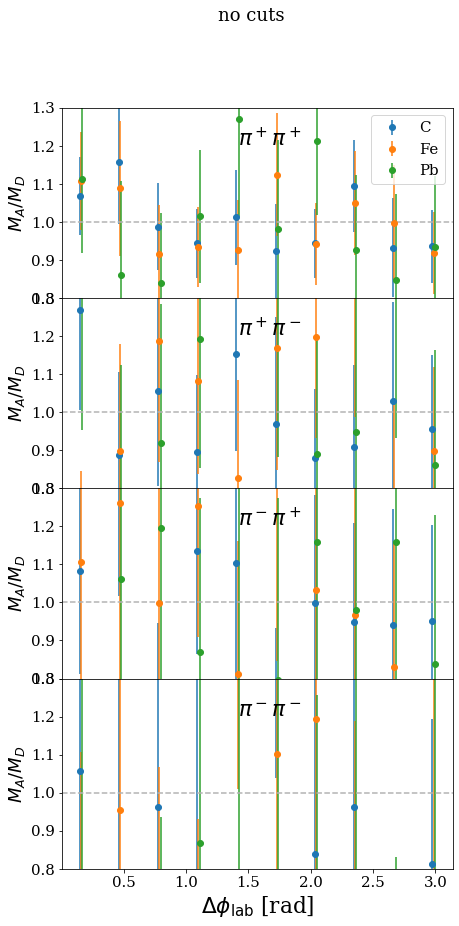

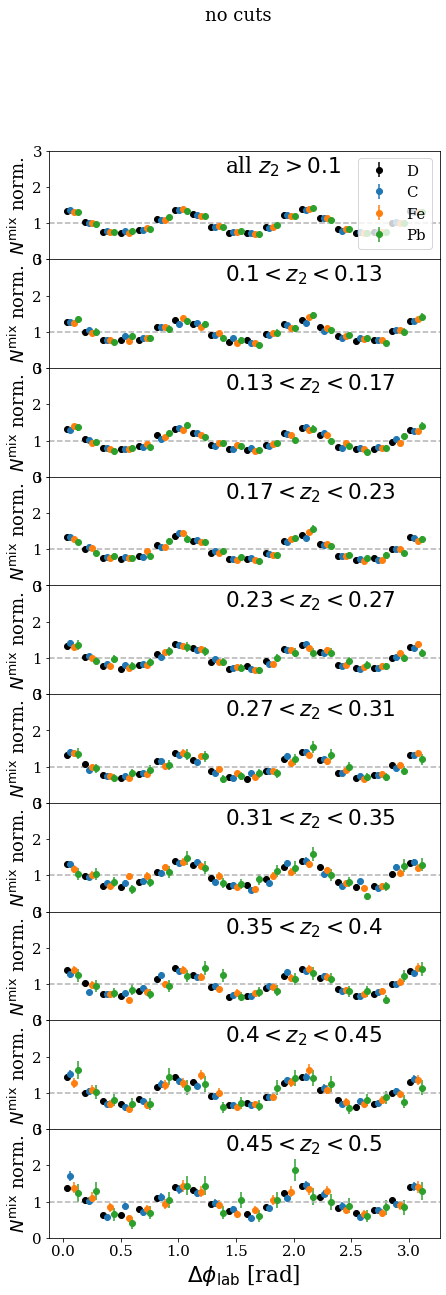

In [38]:
imp.reload(correlation_plots)
q = "h1_z>0.5 and h2_z>0.1"
q_trig = "h1_z>0.5"
for mixtag,label in zip(('','xQ2_', 'no_ecuts_'),('angle, x cuts', 'x, Q2 cuts','no cuts')):
    for cmorlab in 'cm lab'.split():
        xlbl = f'$\\Delta\\phi_{{\\mathrm{{{cmorlab}}}}}$ [rad]'
        tag = f'dphi_{cmorlab}'
        xvar = f'abs(diff_phi_{cmorlab})'
        bins = 10
        xoffset=.01
        #for xlbl,tag, xvar,rang,bins,xoffset in [['$\\Delta\\phi$ [rad]','dphi','abs(diff_phi_cm)',(0,np.pi),10,.05],
        #                    ['$z_2$', 'z2','h2_z',(.1,0.5),8,.01]]:
        #if xvar == 'h2_z':
        #    continue
        fig,axs  = plt.subplots(4,1, figsize=(7,14),sharex='all')
        fig.subplots_adjust(hspace=0)
        for query,lbl,ax in zip(('h1_pid==211 and h2_pid==211','h1_pid==211 and h2_pid==-211',
                            'h1_pid==-211 and h2_pid==211', 'h1_pid==-211 and h2_pid==-211'), r"$\pi^+\pi^+$ $\pi^+\pi^-$ $\pi^-\pi^+$ $\pi^-\pi^-$".split(),
                            axs):
            for a,color,offsetX in zip('C Fe Pb'.split(),"tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,3)):
                mixed_A = dfs_mixed[mixtag+a+'_2pi'].query(q)
                mixed_D = dfs_mixed[mixtag+"D_"+a+'_2pi'].query(q)
                plt.sca(ax)
                correlation_plots.plot_uncertainty_from_mixed(mixed_A.query(query),mixed_D.query(query),bins=bins,
                       label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
            plt.gca().set_ylabel("$M_A/M_D$",fontsize='large')
            plt.gca().set_xlabel(xlbl)
            plt.text(0.45, .8, lbl,fontsize='x-large',transform = ax.transAxes)
            plt.gca().set_ylim(.8,1.3) 
            plt.axhline(1, color='0.7',linestyle='--')
        axs[0].legend()
        fig.suptitle(label)
        plt.savefig(image_dir + f"/syst_mixed_R2h_{tag}.pdf",bbox_inches='tight')
        
        partitions = ((0.1,0.13,1),(0.13,0.17,2),(0.17,0.23,3),
              (0.23,0.27,4),(0.27,0.31,5),(0.31,0.35,6),(0.35,0.4,7),(0.40,0.45,8),(0.45,0.5,9))
        
        fig,axs = plt.subplots(len(partitions)+1,1, figsize=(7,20),sharex='all',sharey='all')
        fig.subplots_adjust(hspace=0)
        fig.suptitle(label)
        yss = []
        xss = []
        dyss = []
        for txt,lbl, q,ax in [["all","all $z_2>0.1$", "h1_z>0.5 and h2_z>0.1", axs[0]]]+\
                        [[f"{mn}<z2<{mx}",f"${mn}<z_2<{mx}$", f"h1_z>0.5 and h2_z>{mn} and h2_z<{mx}",axs[i]] \
                               for mn,mx,i in partitions]:
            xoffset=0.05
            plt.sca(ax)
            ys = []
            xs = []
            dys = []
            for a,color,offsetX in zip('D C Fe Pb'.split(),"k tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,4)):
                mixed_A = dfs_mixed[mixtag+a+"_2pi"].query(q)
                mixed_D = None# dfs_mixed["D_"+a].query(q)

                bins = 20; rang=(0,np.pi);xvar = f'abs(diff_phi_{cmorlab})'

                x,y,dy = correlation_plots.plot_uncertainty_from_mixed(mixed_A,mixed_D,bins=bins,
                       label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
                #print(txt)
                #print(a)
                #print('x,y,dy')
                #for i in range(len(x)):
                    #print("%.5f,%.5f,%.5f"%(x[i],y[i],dy[i]))
                ys.append(y)
                xs.append(x)
                dys.append(dy)
            plt.axhline(1, color='0.7',linestyle='--')
            plt.gca().set_ylabel("$N^{\\mathrm{mix}}$ norm.",fontsize='large')
            plt.gca().set_xlabel(f'$\\Delta\\phi_{{\\mathrm{{{cmorlab}}}}}$ [rad]')
            plt.text(0.45, .8, lbl, fontsize='x-large', transform = plt.gca().transAxes)
            plt.gca().set_ylim(0,3)
            xss.append(xs)
            yss.append(ys)
            dyss.append(dys)

        #for xs,ys,dys in zip(xss,yss,dyss):
            #for x,y,dy in zip(xs,ys,dys):
                #print(np.sqrt(np.mean((y-1)**2)))

        axs[0].legend()
        plt.show()

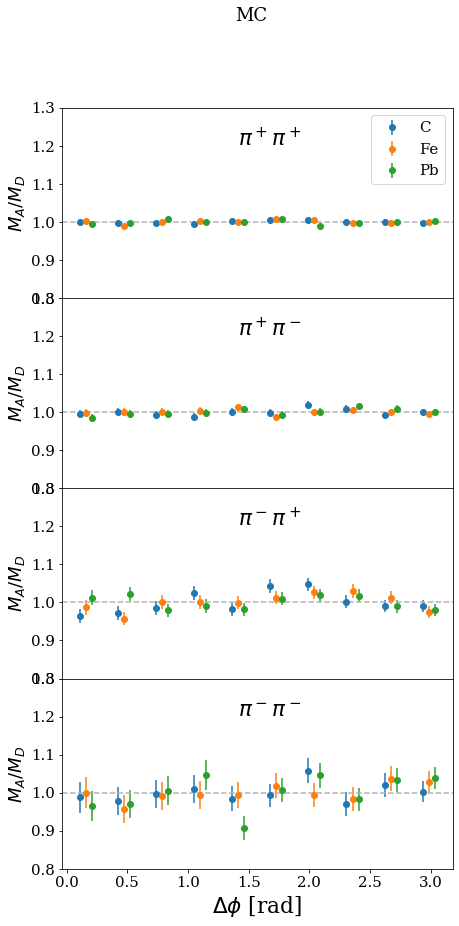

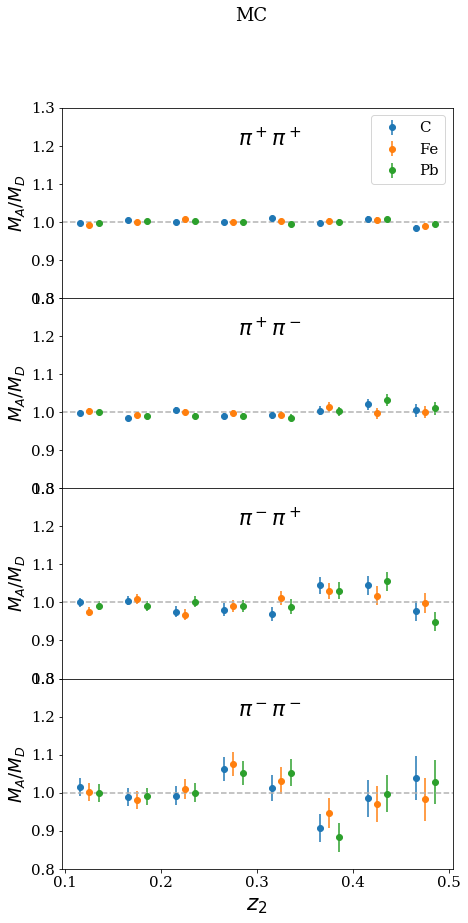

In [11]:
imp.reload(correlation_plots)
q = "h1_z>0.5 and h2_z>0.1"
for xlbl,tag, xvar,rang,bins,xoffset in [['$\\Delta\\phi$ [rad]','dphi','abs(diff_phi_cm)',(0,np.pi),10,.05],
                        ['$z_2$', 'z2','h2_z',(.1,0.5),8,.01]]:
    fig,axs  = plt.subplots(4,1, figsize=(7,14),sharex='all')
    fig.subplots_adjust(hspace=0)
    for query,lbl,ax in zip(('h1_pid==211 and h2_pid==211','h1_pid==211 and h2_pid==-211',
                        'h1_pid==-211 and h2_pid==211', 'h1_pid==-211 and h2_pid==-211'), r"$\pi^+\pi^+$ $\pi^+\pi^-$ $\pi^-\pi^+$ $\pi^-\pi^-$".split(),
                        axs):
        for a,color,offsetX in zip('C Fe Pb'.split(),"tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,3)):
            mixed_A = dfs_mixed['MC_'+a].query(q)
            mixed_D = dfs_mixed["MC_D2"].query(q)
            plt.sca(ax)
            correlation_plots.plot_uncertainty_from_mixed(mixed_A.query(query),mixed_D.query(query),bins=bins,
                   label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
        plt.gca().set_ylabel("$M_A/M_D$",fontsize='large')
        plt.gca().set_xlabel(xlbl)
        plt.text(0.45, .8, lbl,fontsize='x-large',transform = ax.transAxes)
        plt.gca().set_ylim(.8,1.3) 
        plt.axhline(1, color='0.7',linestyle='--')
    axs[0].legend()
    fig.suptitle("MC")
    plt.savefig(image_dir + f"/syst_mixed_R2h_{tag}.pdf",bbox_inches='tight')

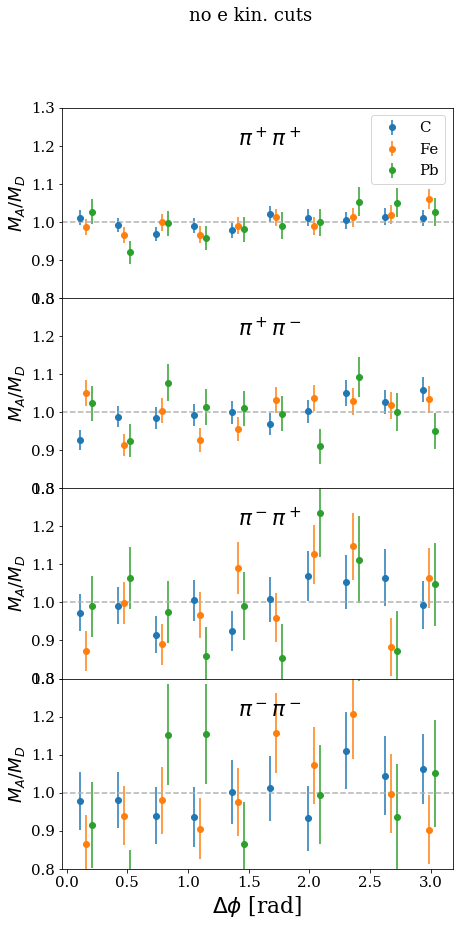

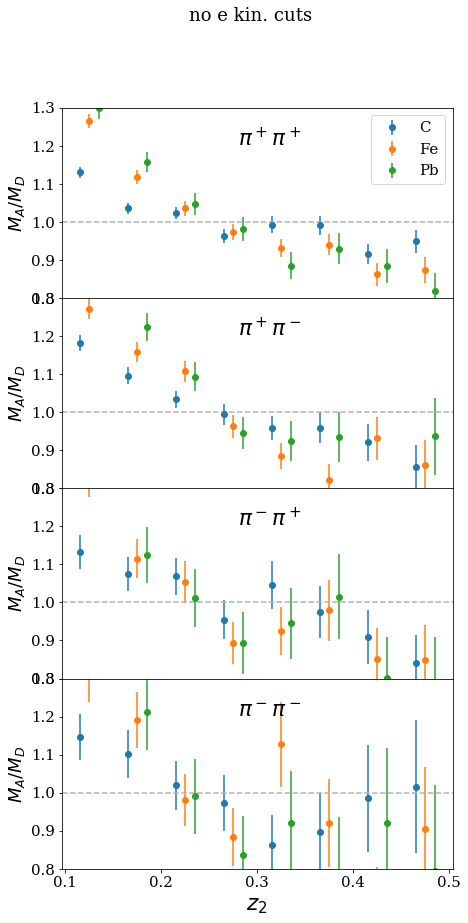

In [12]:
imp.reload(correlation_plots)
q = "h1_z>0.5 and h2_z>0.1"
for xlbl,tag, xvar,rang,bins,xoffset in [['$\\Delta\\phi$ [rad]','dphi','abs(diff_phi_cm)',(0,np.pi),10,.05],
                        ['$z_2$', 'z2','h2_z',(.1,0.5),8,.01]]:
    fig,axs  = plt.subplots(4,1, figsize=(7,14),sharex='all')
    fig.subplots_adjust(hspace=0)
    for query,lbl,ax in zip(('h1_pid==211 and h2_pid==211','h1_pid==211 and h2_pid==-211',
                        'h1_pid==-211 and h2_pid==211', 'h1_pid==-211 and h2_pid==-211'), r"$\pi^+\pi^+$ $\pi^+\pi^-$ $\pi^-\pi^+$ $\pi^-\pi^-$".split(),
                        axs):
        for a,color,offsetX in zip('C Fe Pb'.split(),"tab:blue tab:orange tab:green".split(),np.linspace(-xoffset,xoffset,3)):
            mixed_A = dfs_mixed['no_ecuts_'+a].query(q)
            mixed_D = dfs_mixed["no_ecuts_D_"+a].query(q)
            plt.sca(ax)
            correlation_plots.plot_uncertainty_from_mixed(mixed_A.query(query),mixed_D.query(query),bins=bins,
                   label=a,color=color,offsetX=offsetX,alpha=1,xvar=xvar,range=rang)
        plt.gca().set_ylabel("$M_A/M_D$",fontsize='large')
        plt.gca().set_xlabel(xlbl)
        plt.text(0.45, .8, lbl,fontsize='x-large',transform = ax.transAxes)
        plt.gca().set_ylim(.8,1.3) 
        plt.axhline(1, color='0.7',linestyle='--')
    axs[0].legend()
    fig.suptitle("no e kin. cuts")
    plt.savefig(image_dir + f"/syst_mixed_R2h_{tag}.pdf",bbox_inches='tight')

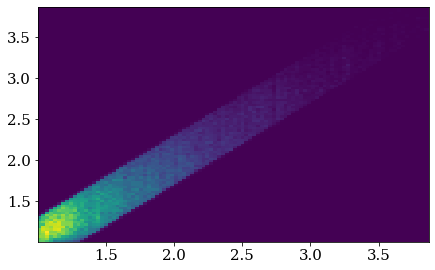

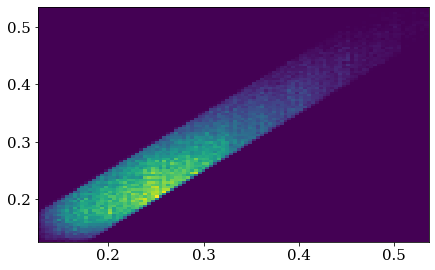

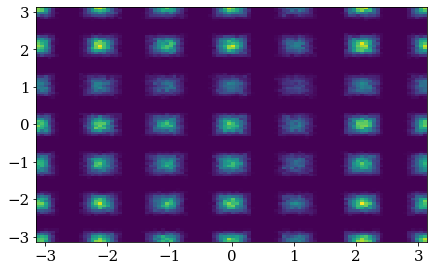

In [15]:
plt.hist2d(dfs_mixed['xQ2_C'].Q2,dfs_mixed['xQ2_C'].mixevt_Q2,bins=100)
plt.show()
plt.hist2d(dfs_mixed['xQ2_C'].x,dfs_mixed['xQ2_C'].mixevt_x,bins=100)
plt.show()
plt.hist2d(dfs_mixed['xQ2_C'].e_ph,dfs_mixed['xQ2_C'].mixevt_e_ph,bins=100)
plt.show()

(array([[1.6350e+03, 3.2140e+03, 3.3300e+03, 2.7720e+03, 1.8370e+03,
         1.1830e+03, 6.3000e+02, 3.3900e+02, 1.3600e+02, 2.4000e+01],
        [4.2220e+03, 8.7510e+03, 9.1160e+03, 7.3700e+03, 5.0320e+03,
         3.0540e+03, 1.7070e+03, 9.0400e+02, 3.4100e+02, 6.3000e+01],
        [5.4660e+03, 1.0833e+04, 1.1275e+04, 9.1370e+03, 6.3360e+03,
         3.8350e+03, 2.0940e+03, 9.9700e+02, 4.1000e+02, 8.7000e+01],
        [4.9420e+03, 9.8660e+03, 1.0069e+04, 8.4990e+03, 5.6640e+03,
         3.5310e+03, 1.8950e+03, 9.6400e+02, 4.0400e+02, 8.6000e+01],
        [3.6320e+03, 7.3310e+03, 7.2700e+03, 5.9250e+03, 4.0860e+03,
         2.5400e+03, 1.4280e+03, 6.7600e+02, 2.6100e+02, 7.1000e+01],
        [2.1560e+03, 4.0750e+03, 4.3280e+03, 3.5570e+03, 2.4270e+03,
         1.4620e+03, 8.5900e+02, 3.9400e+02, 1.5200e+02, 4.0000e+01],
        [1.2050e+03, 2.4670e+03, 2.5680e+03, 2.1920e+03, 1.4020e+03,
         8.9900e+02, 4.9000e+02, 2.3000e+02, 1.0200e+02, 2.5000e+01],
        [5.8500e+02, 1.1980

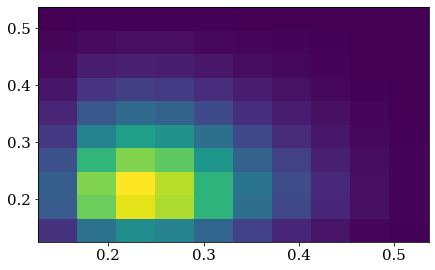

In [133]:
df = dfs_mixed['no_ecuts_C']
plt.hist2d(df.x,df.mixevt_x)